# Import dependencies

In [1]:
from matplotlib import pyplot as plt
import missingno as msno 
import numpy as np
import pandas as pd
import scipy
from scipy.stats import probplot, chi2_contingency, spearmanr
import seaborn as sns
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report, make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

--------------------

# Part 2
_"Produce descriptive statistics and plots describing the individual variables and their pairwise associations with one another. Pay particular attention to the associations of income and annual savings with all other variables. Comment on the results. Is there anything particularly interesting? Is there anything that doesn’t make sense?"_

## Summary

**Key actions/observations:**

* Descriptive statistics and frequency distributions are computed for all variables within the training set. As might be expected, the results are similar to that observed in part 1 for the raw dataset (prior to data cleansing).
  
* Given the relatively high proportion of zeros in the ‘annual_net_savings_lbg’ feature, it was decided the task of explaining annual savings in part 3 would be treated as two separate tasks. Namely, an ordinary least squares model would be used to explain savings above zero. Whilst a logistic regression model would be used to explain the probability of having zero savings.

* After filtering individuals with zero savings from the data, the strength of pairwise associations between variables for individuals with non-zero savings was assessed. A combination of correlation coefficients, scatter plots and independence tests revealed the following:

    1. High correlation between ‘annual_net_savings_lbg’ and the predictive variables 'age' and 'savings_bal_lbg'. 
       
        Note: A scatter plot displayed a non-linear relationship between age and ‘annual_net_savings_lbg’, while a breakpoint was evident in the trend between ‘annual_net_savings_lbg’ and ‘savings_bal_lbg’. Given these predictive variables' also have non-normal distributions, the computed Pearson correlation coefficients are not an accurate assessment of association strength.
  
    2. A moderate linear correlation between ‘annual_net_savings_lbg’ and the predictive variables 'net_salary', 'observed_income', 'observed_surplus', 'credit_score', and 'other_income'.
  
    3. Weak association between ‘annual_net_savings_lbg‘ and both 'gambling_spend' and 'childcare_spend'.
       
    4. Multicollinearity observed among the predictive variables 'observed_income', 'observed_surplus', 'other_income', and 'net_salary'. Similarly, both 'age' and 'savings_bal_lbg' were highly correlated.
       
    5. Independence among categorical variables.
 
    6. The relationship between 'age' and ‘annual_net_savings_lbg’ appears to be non-linear with breakpoints at 22 and 55 years of age. While the linear relationship between 'savings_bal_lbg' and ‘annual_net_savings_lbg’ has a clear breakpoint at roughly $2\times10^6$ for 'savings_bal_lbg'.

## Import cleaned data

In [2]:
# Training data
clean_train_df = pd.read_csv('../data/cleaned/clean_train.csv')
print(f"Number of rows: {clean_train_df.shape[0]}")
print(f"Number of columns: {clean_train_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 23392
Number of columns: 15


cust_unique_id  age gender ethnicity_group geo_region  net_salary  \
0           12711   40      F   White British  Southwest    45385.08   
1           11308   22      M     South Asian   Scotland    47307.51   
2           29607   32      M   White British  Southwest    54393.92   
3           17150   27  Other   White British   Scotland    46380.41   
4           28362   34      M   White British  Southeast    68217.27   

   observed_income  childcare_spend  gambling_spend  observed_surplus  \
0         52337.85              0.0          757.12          33385.24   
1         57734.58              0.0            0.00          34201.97   
2         64505.17              0.0            0.00          64505.17   
3         55337.96              0.0            0.00          55337.96   
4         86613.91              0.0            0.00          60559.66   

   credit_score  savings_bal_lbg  annual_net_savings_lbg  other_income  \
0       1522.26        477383.97                    0.00       6952.77   
1       1563.66             0.00                    0.00      10427.06   
2       1708.02        271540.82                19258.84      10111.26   
3       1620.99         65397.27                16928.97       8957.56   
4       2140.43        535651.79                24985.39      18396.64   

   housing_spend  
0      18195.490  
1      23532.610  
2      21109.689  
3      23471.349  
4      26054.250

In [3]:
# Test data
clean_test_df = pd.read_csv('../data/cleaned/clean_test.csv')
print(f"Number of rows: {clean_test_df.shape[0]}")
print(f"Number of columns: {clean_test_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 5862
Number of columns: 15


cust_unique_id  age gender ethnicity_group geo_region  net_salary  \
0           12711   40      F   White British  Southwest    45385.08   
1           11308   22      M     South Asian   Scotland    47307.51   
2           29607   32      M   White British  Southwest    54393.92   
3           17150   27  Other   White British   Scotland    46380.41   
4           28362   34      M   White British  Southeast    68217.27   

   observed_income  childcare_spend  gambling_spend  observed_surplus  \
0         52337.85              0.0          757.12          33385.24   
1         57734.58              0.0            0.00          34201.97   
2         64505.17              0.0            0.00          64505.17   
3         55337.96              0.0            0.00          55337.96   
4         86613.91              0.0            0.00          60559.66   

   credit_score  savings_bal_lbg  annual_net_savings_lbg  other_income  \
0       1522.26        477383.97                    0.00       6952.77   
1       1563.66             0.00                    0.00      10427.06   
2       1708.02        271540.82                19258.84      10111.26   
3       1620.99         65397.27                16928.97       8957.56   
4       2140.43        535651.79                24985.39      18396.64   

   housing_spend  
0      18195.490  
1      23532.610  
2      21109.689  
3      23471.349  
4      26054.250

In [4]:
# Update cust_unique_id -> categorical dtype
clean_train_df['cust_unique_id'] = pd.Categorical(
    clean_train_df['cust_unique_id'], list(clean_train_df['cust_unique_id'].unique()), ordered=True
)
clean_test_df['cust_unique_id'] = pd.Categorical(
    clean_test_df['cust_unique_id'], list(clean_test_df['cust_unique_id'].unique()), ordered=True
)

In [5]:
print(f'\n-----------------------------Training set-----------------------------\n')
display(clean_train_df.info())
print(f'\n-----------------------------Test set-----------------------------\n')
display(clean_train_df.info())


-----------------------------Training set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23392 entries, 0 to 23391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cust_unique_id          23392 non-null  category
 1   age                     23392 non-null  int64   
 2   gender                  23392 non-null  object  
 3   ethnicity_group         23392 non-null  object  
 4   geo_region              23392 non-null  object  
 5   net_salary              23392 non-null  float64 
 6   observed_income         23392 non-null  float64 
 7   childcare_spend         23392 non-null  float64 
 8   gambling_spend          23392 non-null  float64 
 9   observed_surplus        23392 non-null  float64 
 10  credit_score            23392 non-null  float64 
 11  savings_bal_lbg         23392 non-null  float64 
 12  annual_net_savings_lbg  23392 non-null  float64 
 13  oth

None


-----------------------------Test set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23392 entries, 0 to 23391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cust_unique_id          23392 non-null  category
 1   age                     23392 non-null  int64   
 2   gender                  23392 non-null  object  
 3   ethnicity_group         23392 non-null  object  
 4   geo_region              23392 non-null  object  
 5   net_salary              23392 non-null  float64 
 6   observed_income         23392 non-null  float64 
 7   childcare_spend         23392 non-null  float64 
 8   gambling_spend          23392 non-null  float64 
 9   observed_surplus        23392 non-null  float64 
 10  credit_score            23392 non-null  float64 
 11  savings_bal_lbg         23392 non-null  float64 
 12  annual_net_savings_lbg  23392 non-null  float64 
 13  other_i

None

## Descriptive statistics

### Summary statistics

**1) Continuous variables**

* A large difference between mean and median values suggests the following features' distributions are skewed and/or contain outliers: childcare_spend, gambling_spend, observed_surplus and savings_bal_lbg.

* The quantiles for childcare_spend and gambling_spend indicate at least 75% of their values are zero.

In [6]:
clean_train_df.select_dtypes(include=['number']).describe()

age     net_salary  observed_income  childcare_spend  \
count  23392.000000   23392.000000     23392.000000     23392.000000   
mean      41.655566   56548.527536     69220.571330       585.626551   
std       15.400009   11870.864002     14696.477614      2510.828494   
min        4.000000   -1000.000000     32518.450000         0.000000   
25%       29.000000   50373.510000     59185.625000         0.000000   
50%       42.000000   56575.880000     67270.710000         0.000000   
75%       55.000000   64800.010000     82122.495000         0.000000   
max       68.000000  104374.080000    130957.700000     16784.820000   

       gambling_spend  observed_surplus  credit_score  savings_bal_lbg  \
count    23392.000000      23392.000000  23392.000000     2.339200e+04   
mean        86.801052      51267.079483   1810.719393     8.405096e+05   
std       1417.652457      15848.924804    228.428364     7.318075e+05   
min          0.000000     -71821.480000   1270.000000     0.000000e+00   
25%          0.000000      40212.817500   1659.070000     1.514958e+05   
50%          0.000000      50051.660000   1802.965000     7.121266e+05   
75%          0.000000      60262.457500   1993.232500     1.396350e+06   
max     121227.120000     128700.410000   2719.650000     3.615059e+06   

       annual_net_savings_lbg  other_income  housing_spend  
count            23392.000000  23392.000000   23392.000000  
mean             21332.121706  12809.335570   24143.601452  
std              10003.304356   5967.150029    4428.430080  
min                  0.000000      0.000000   10573.570000  
25%              16897.822500   9462.912500   20861.823250  
50%              22878.645000  12101.268000   24235.227500  
75%              28365.630000  18293.207500   27566.162500  
max              42693.690000  29752.890000   41872.550000

**2) Categorical variables**
* No duplicate values are present in cust_unique_id.

* The number of unique values in the gender, ethnicity_group and geo_region columns is relatively low.

In [7]:
clean_train_df.select_dtypes(include=['object', 'category']).describe()

cust_unique_id gender ethnicity_group geo_region
count            23392  23392           23392      23392
unique           23392      4               5          6
top              12711      F   White British  Southeast
freq                 1  11359           19366      10426

### Frequency distributions

**1) Continuous variables**
* A relatively uniform distribution is observed for age.

* A positive skew is exhibited by savings_bal_lbg.

* The childcare_spend and gambling_spend columns contain a high proportion of zeros (94.6% and 90.8%, respectively) 

* Both gambling_spend and observed_surplus contain an outlier.

* Ommitting zero values in the childcare_spend column reveals a symmetric distribution.

* Ommitting zero values in the gambling_spend column reveals a positive skew.

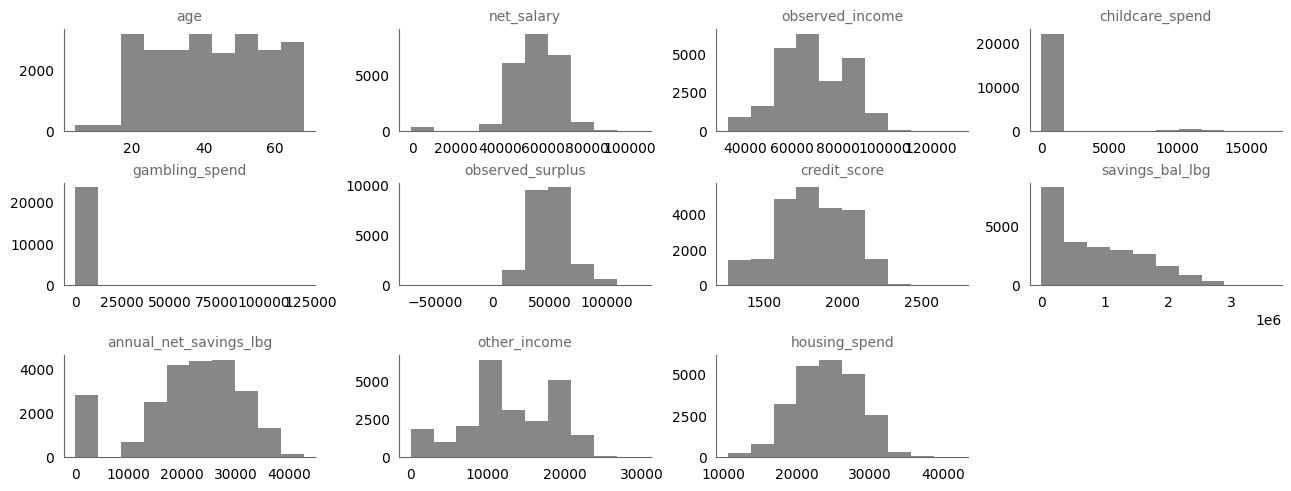

In [8]:
fig, axes = plt.subplots(
    nrows=3, ncols=4, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes(include=['number']).columns:
    axes[i].hist(clean_train_df[col], color='dimgray', alpha=0.8, label='')
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

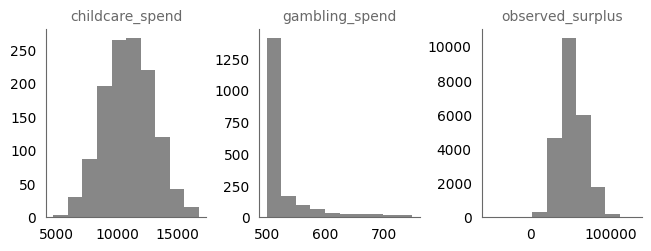

In [9]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, constrained_layout=True, figsize=(6.4, 4.8/2)
)

# Histogram for childcare_spend (excluding zeros)
axes[0].hist(clean_train_df.loc[clean_train_df['childcare_spend'] != 0,
             'childcare_spend'], color='dimgray', alpha=0.8, label=''
            )

# Histogram for gambling_spend (excluding zeros & outliers)
percentile_lower = np.percentile(clean_train_df['gambling_spend'], 91)
percentile_upper = np.percentile(clean_train_df['gambling_spend'], 99)
filter_condition = (clean_train_df['gambling_spend'] >= percentile_lower) & (
    clean_train_df['gambling_spend'] <= percentile_upper
)
axes[1].hist(clean_train_df.loc[filter_condition, 'gambling_spend'],
             color='dimgray', alpha=0.8, label=''
            )

# Histogram for observed_surplus (excluding zeros & max value)
axes[2].hist(clean_train_df.loc[clean_train_df['observed_surplus'] != clean_train_df['observed_surplus'].min(
), 'observed_surplus'], color='dimgray', alpha=0.8, label=''
            )

axes[0].set_title('childcare_spend', fontsize=10, color='dimgray')
axes[1].set_title('gambling_spend', fontsize=10, color='dimgray')
axes[2].set_title('observed_surplus', fontsize=10, color='dimgray')
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

**2) Categorical variables**
* No duplicate values are present in cust_unique_id.

* The distributions of gender, ethnicity_group and geo_region are imbalanced.

* One of the gender categories is called '999'. The meaning is unclear.

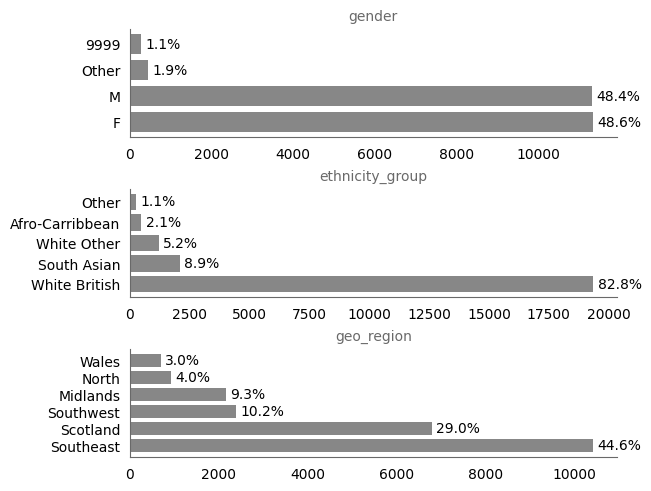

In [10]:
# Frequency plots
fig, axes = plt.subplots(
    nrows=3, ncols=1, constrained_layout=True, figsize=(6.4, 4.8)
)
i = 0
for col in ['gender', 'ethnicity_group', 'geo_region']:
    counts = clean_train_df[col].value_counts()
    percs = clean_train_df[col].value_counts(normalize=True)
    rects = axes[i].barh(counts.index, counts.values,
                         color='dimgray', alpha=0.8)
    axes[i].bar_label(rects, labels=[str(round(x*100, 1)) +
                      '%' for x in percs.values], padding=3)
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

### Pairwise associations

* Given the relatively high proportion of zeros in the ‘annual_net_savings_lbg’ feature, it was decided the task of explaining annual savings in part 3 would be treated as two separate tasks. Namely, an ordinary least squares model would be used to explain savings above zero. 

* Pairwise associations are assessed below after ommitting individuals with zero values in the 'annual_net_savings_lbg' column.

In [11]:
# Filter out zero values
clean_train_df = clean_train_df.loc[clean_train_df['annual_net_savings_lbg']!=0].reset_index(drop=True)

#### Continuous-continuous
* Linear relationships are observed between many of the variables.
  
* Pearson correlation coefficient is used to estimate the strength of linear associations. Given the observed departures from normality and non-linear trends between specific variables shown later (i.e. age-annual savings), these values should be treated as rough estimates of association strength.

* The correlation matrix indicates multicollinearity among the predictive variables 'observed_income', 'observed_surplus', 'other_income', and 'net_salary'. Similarly, both 'age' and 'savings_bal_lbg' were highly correlated.

* 'Childcare_spend' and 'gambling_spend' do not appear to be strongly correlated with any variables.

**Background**

**_1) Covariance_**

* Definition:

    $Cov(X,Y) = \mathbb{E}\bigl[(X-\mathbb{E}X)(Y-\mathbb{E}Y) \bigr]$

* Properties:

    $Cov(X,Y) \in [-\infty, +\infty]$

    $Cov(X, Y) = 0: $ No linear association between $X$ & $Y$

* Assumptions:

    * Normal distribution for $X$ and $Y$

    * Linear relationship between $X$ and $Y$
 
**_2) Pearson correlation coefficient_**

* Definition:

    $r = \frac{Cov(X, Y)}{\sqrt{Var(X)Var(Y)}} = \frac{Cov(X, Y)}{Std(X)Std(Y)}$

* Properties:

    $r \in [-1, 1]$

    $r=1:$ Perfect $+ve$ linear correlation where $Y=mX + c$ and $m>0$

    $r=-1:$ Perfect $-ve$ linear correlation where $Y=mX + c$ and $m<0$

    $r=0:$ No linear association between $X$ and $Y$ (aka independence)

* Assumptions:

    * Normal distribution for $X$ and $Y$

    * Linear relationship between $X$ and $Y$

**_3) Spearman's rank correlation coefficient_**

* Definition:

    $r_s = \frac{Cov\bigl(r(X), r(Y)\bigr)}{\sqrt{Var\bigl(r(X)\bigr)Var\bigl(r(Y)\bigr)}} = \frac{Cov\bigl(r(X), r(Y)\bigr)}{Std\bigl(r(X)\bigr)Std\bigl(r(Y)\bigr)}$

    *Where the raw scores for $X$ and $Y$ are converted to ranks.*

* Properties:

    $r_s \in [-1, 1]$

    $r_s = 1:$ Observations in $X$ and $Y$ have the same rank. Perfectly increasing monotonic relationship. 

    $r_s = -1:$ Observations in $X$ and $Y$ have opposing ranks. Perfectly decreasing monotonic relationship. 

    $r_s = 0:$ No monotonic relationship.

* Assumptions:

    - Non-parametric
      
    - Relationship between $X$ and $Y$ must be monotonic (entirely non-increasing or non-decreasing)
 
      <img src="./figures/increasing_monotonic.png" align="centre" width="150" />  <img src="./figures/decreasing_monotonic.png" align="centre" width="150" />
 



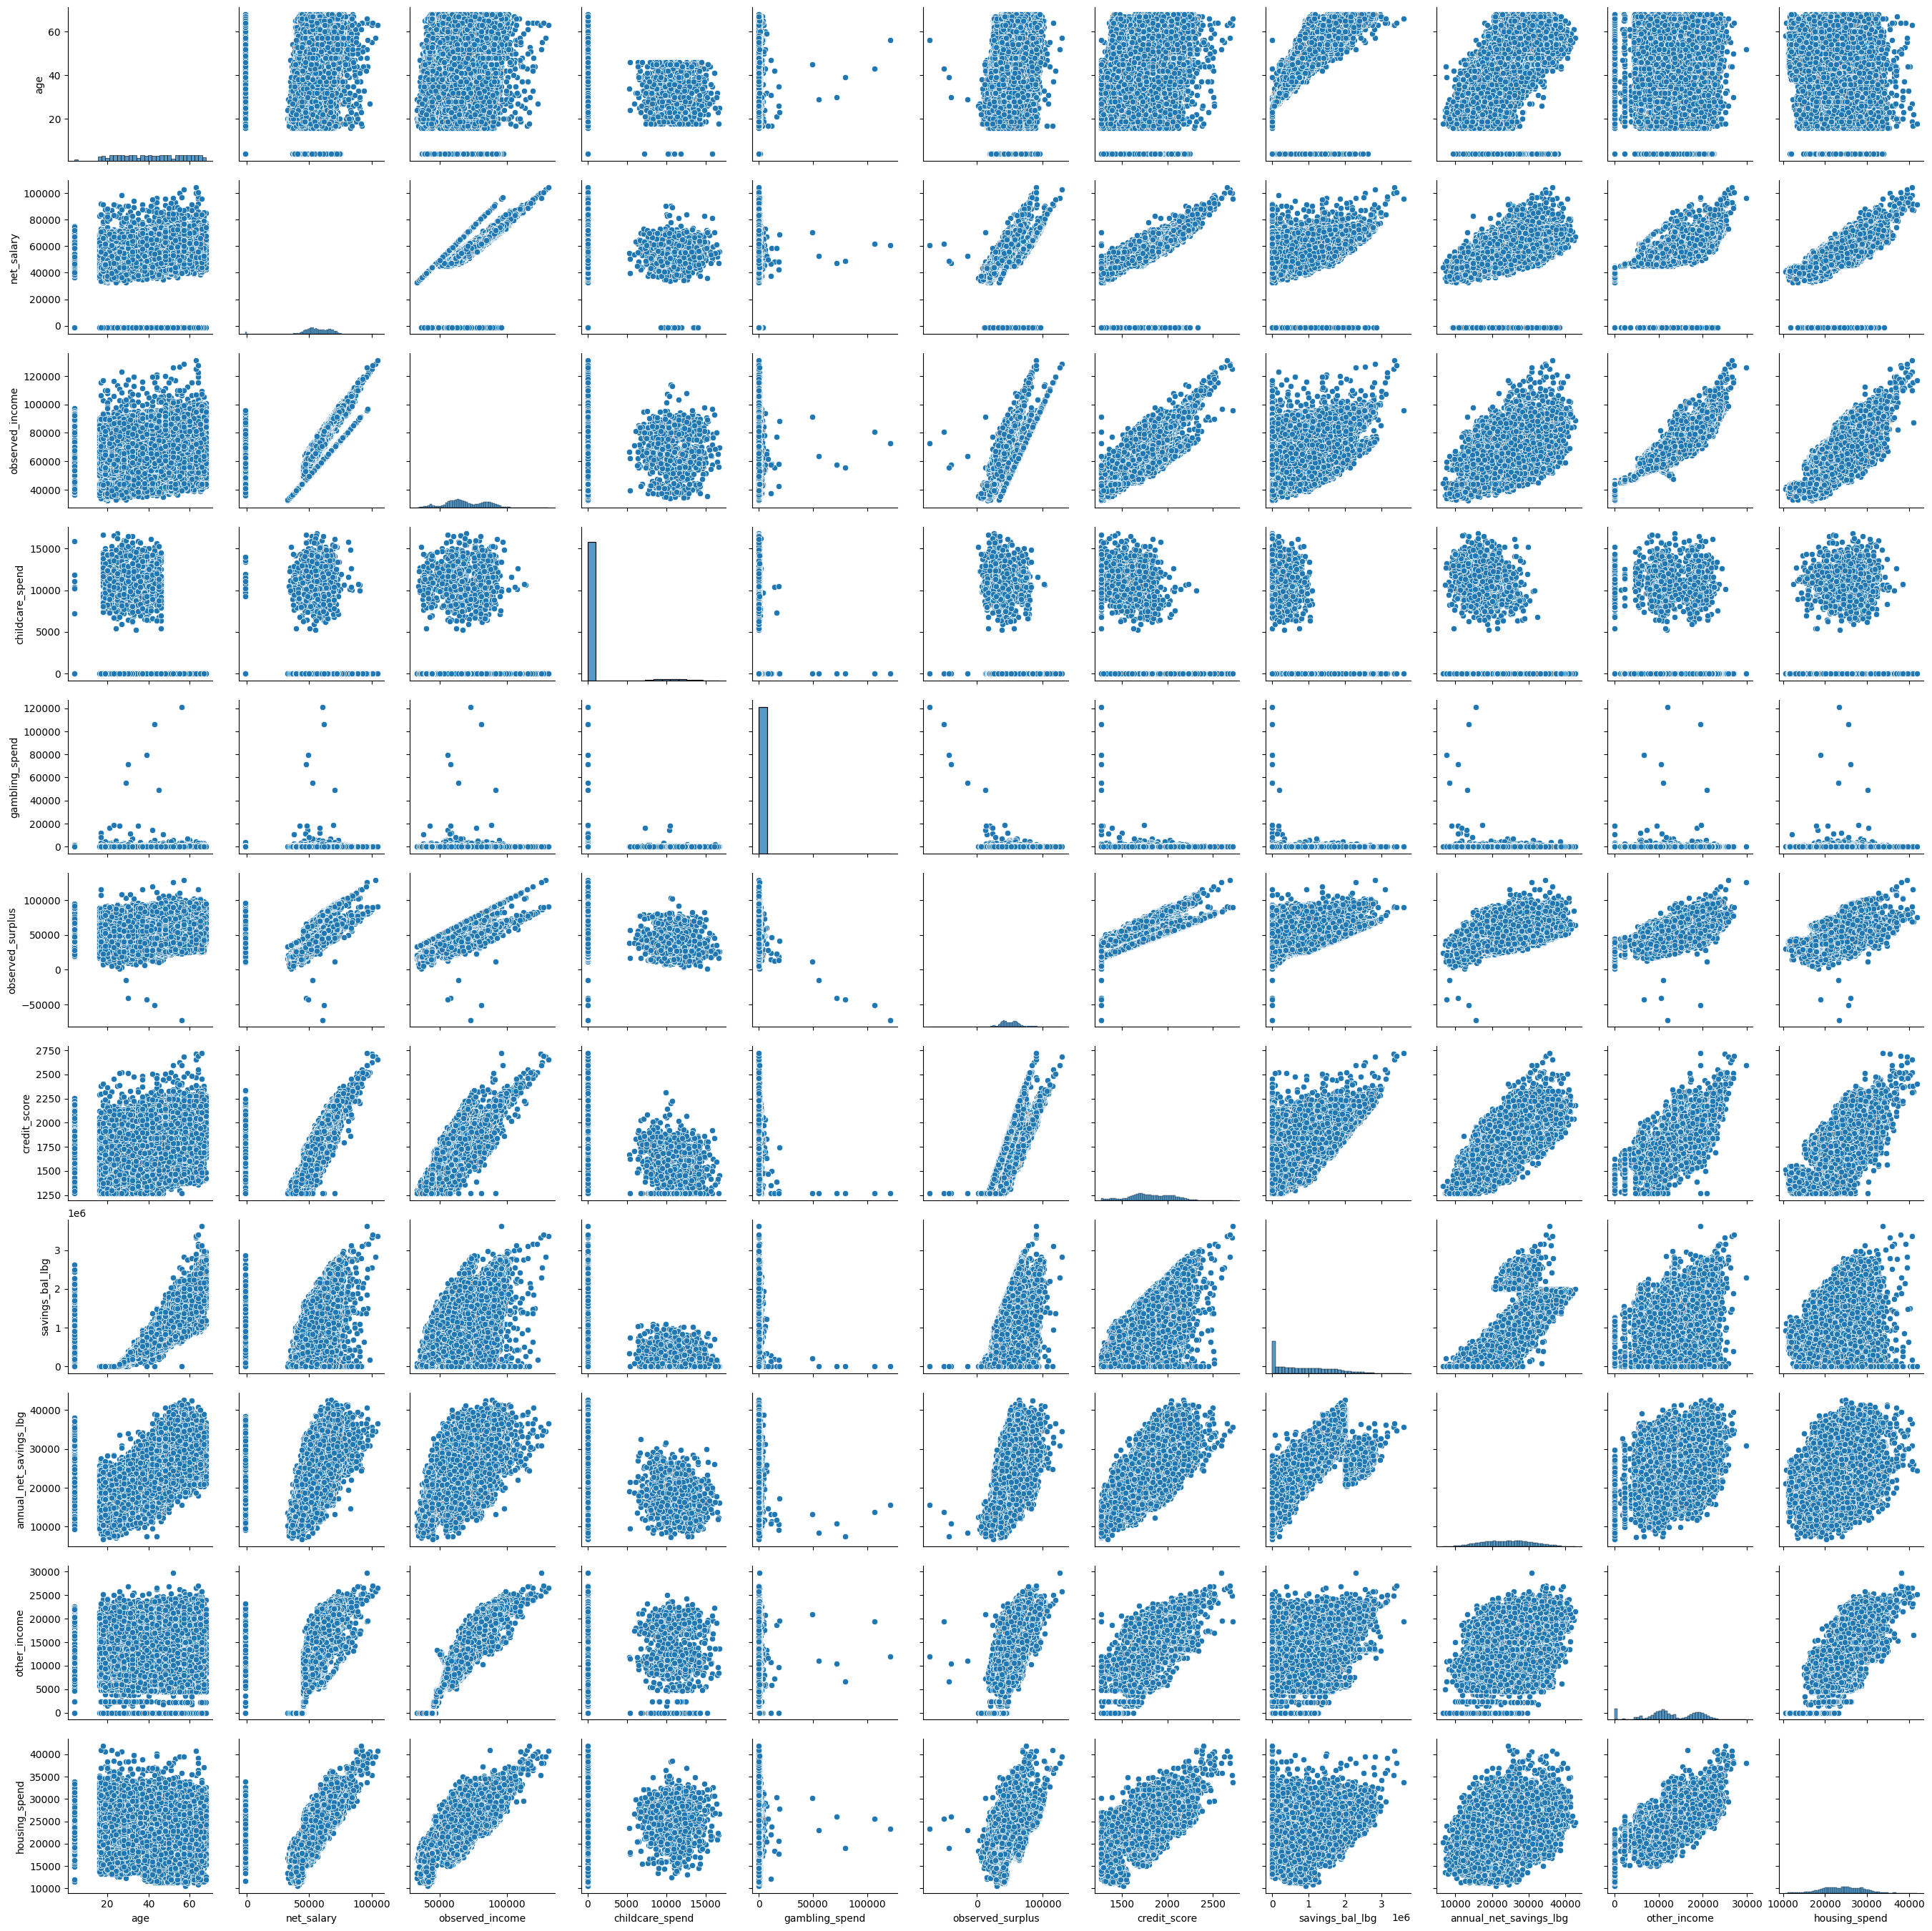

In [12]:
# Matrix of scatter plots
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
sns.pairplot(
    clean_train_df.select_dtypes(include=['number']), diag_kind='hist'
)

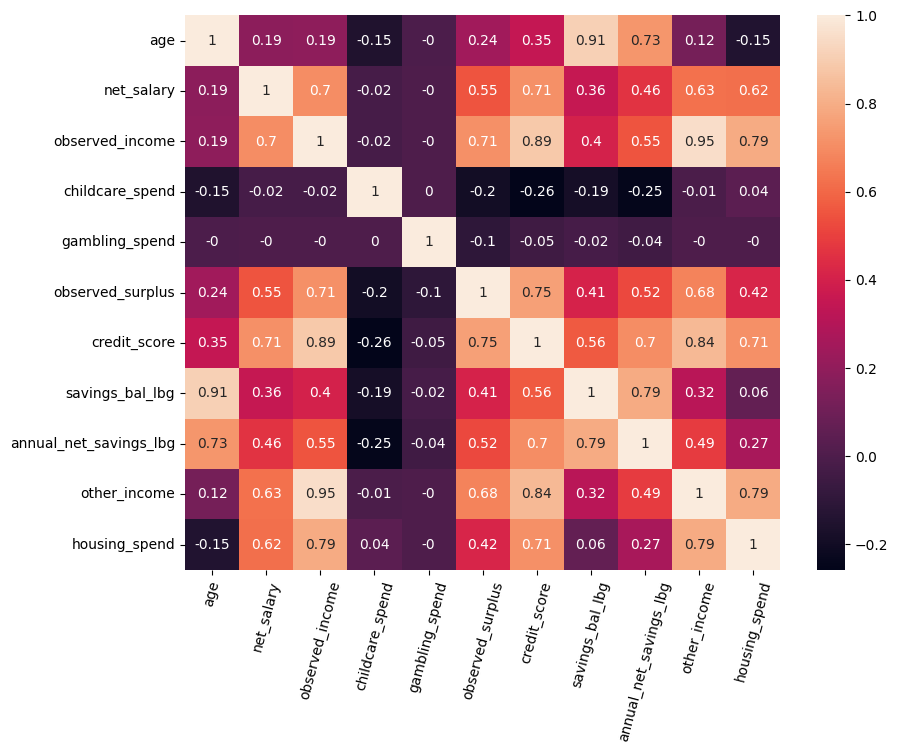

In [13]:
# Pearson correlation matrix
pearson_corr = clean_train_df.select_dtypes(
    include=['number']).corr(method='pearson'
                            )
fig, axes = plt.subplots(
    figsize=(6.4*1.5, 4.8*1.5)
)
sns.heatmap(pearson_corr, ax=axes, annot=pearson_corr.values.round(2))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

In [14]:
# Print abs(coefficients) > 0.5
correlation_list = []
# Iterate over upper triangle (to avoid duplicates)
for i in range(len(pearson_corr.columns)):
    for j in range(i + 1, len(pearson_corr.columns)):
        var_1 = pearson_corr.columns[i]
        var_2 = pearson_corr.columns[j]
        corr = pearson_corr.iloc[i, j]
        correlation_list.append((var_1, var_2, corr))

correlation_list = sorted(
    correlation_list, key=lambda x: np.abs(x[2]), reverse=True
)
correlation_df = pd.DataFrame(
    correlation_list, columns=['variable_1', 'variable_2', 'correlation']
)
correlation_df.loc[abs(correlation_df['correlation']) > 0.5]

variable_1              variable_2  correlation
0    observed_income            other_income     0.954373
1                age         savings_bal_lbg     0.908473
2    observed_income            credit_score     0.885600
3       credit_score            other_income     0.837678
4    observed_income           housing_spend     0.791438
5       other_income           housing_spend     0.790712
6    savings_bal_lbg  annual_net_savings_lbg     0.790302
7   observed_surplus            credit_score     0.754916
8                age  annual_net_savings_lbg     0.726412
9       credit_score           housing_spend     0.713445
10        net_salary            credit_score     0.712928
11   observed_income        observed_surplus     0.710746
12      credit_score  annual_net_savings_lbg     0.703415
13        net_salary         observed_income     0.702391
14  observed_surplus            other_income     0.675675
15        net_salary            other_income     0.626292
16        net_salary           housing_spend     0.617084
17      credit_score         savings_bal_lbg     0.563755
18        net_salary        observed_surplus     0.551588
19   observed_income  annual_net_savings_lbg     0.550359
20  observed_surplus  annual_net_savings_lbg     0.518904

In [15]:
# Spearman's rank for gambling_spend
spearman_corr = clean_train_df.select_dtypes(
    include=['number']).corr(method='spearman'
                            )
spearman_corr['gambling_spend']

age                      -0.003434
net_salary               -0.001665
observed_income          -0.002547
childcare_spend          -0.003730
gambling_spend            1.000000
observed_surplus         -0.011148
credit_score             -0.022875
savings_bal_lbg          -0.010474
annual_net_savings_lbg   -0.044215
other_income             -0.003499
housing_spend             0.001259
Name: gambling_spend, dtype: float64

**Observed income vs. others**
* A sequence of scatter plots for observed_income vs. other predictive variables confirms multicollinearity.
  
* Gambling_spend does not appear to be associated with observed_income

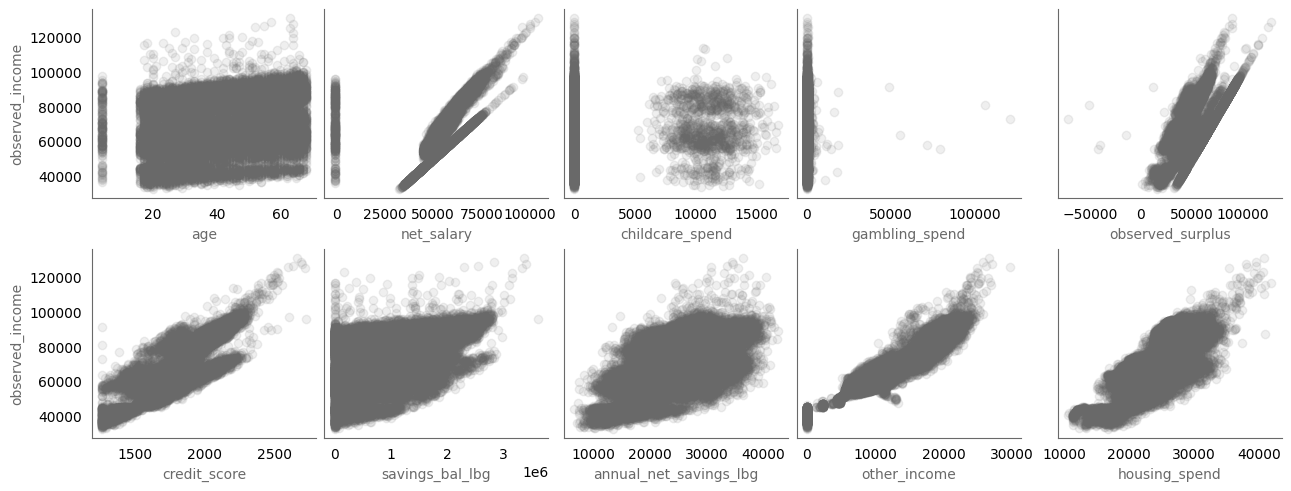

In [16]:
# Plot scatter plots for observed_income
fig, axes = plt.subplots(
    nrows=2, ncols=5, sharey=True, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in [x for x in clean_train_df.select_dtypes('number').columns if x != 'observed_income']:
    axes[i].scatter(
        clean_train_df[col], clean_train_df['observed_income'], color='dimgray', alpha=0.1
    )
    axes[i].set_xlabel(col, fontsize=10, color='dimgray')
    i += 1

axes[0].set_ylabel('observed_income', fontsize=10, color='dimgray')
axes[5].set_ylabel('observed_income', fontsize=10, color='dimgray')
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

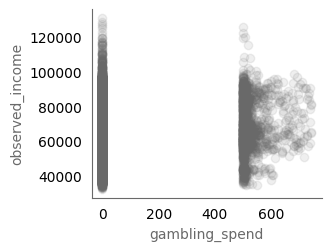

In [17]:
# Replot gambling_spend vs. observed_income

# Filter condition
percentile_lower = np.percentile(clean_train_df['gambling_spend'], 75)
percentile_upper = np.percentile(clean_train_df['gambling_spend'], 99)
filter_condition = (clean_train_df['gambling_spend'] >= percentile_lower) & (
    clean_train_df['gambling_spend'] <= percentile_upper
)

# Plot
fig, axes = plt.subplots(
    nrows=1, ncols=1, sharey=True, constrained_layout=True, figsize=(6.4/2, 4.8/2)
)
axes.scatter(
    clean_train_df.loc[filter_condition, 'gambling_spend'], clean_train_df.loc[filter_condition, 'observed_income'], color='dimgray', alpha=0.1
)
axes.set_xlabel('gambling_spend', fontsize=10, color='dimgray')
axes.set_ylabel('observed_income', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

**Annual savings vs. others**
* A moderate linear correlation is observed between ‘annual_net_savings_lbg’ and the predictive variables 'net_salary', 'observed_income', 'observed_surplus', 'credit_score', and 'other_income'.

* The relationship between 'age' and ‘annual_net_savings_lbg’ appears to be non-linear with breakpoints at 22 and 55 years of age.

* The linear relationship between 'savings_bal_lbg' and ‘annual_net_savings_lbg’ has a clear breakpoint at roughly $2\times10^6$.

* 'Gambling_spend' does not appear to be correlated with annual savings.

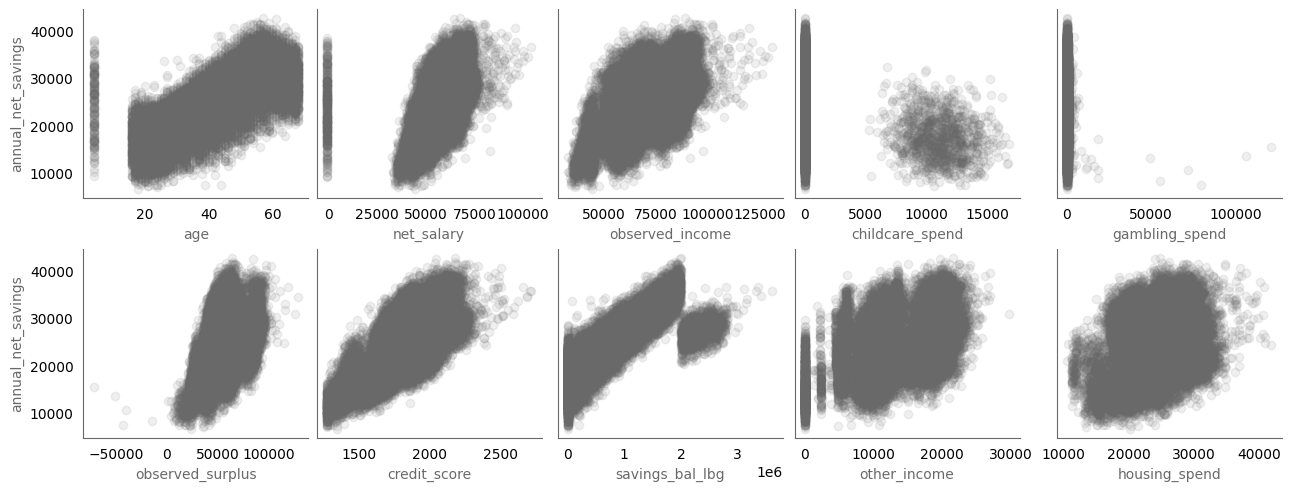

In [18]:
# Plot scatter plots for annual_net_savings
fig, axes = plt.subplots(
    nrows=2, ncols=5, sharey=True, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in [x for x in clean_train_df.select_dtypes('number').columns if x != 'annual_net_savings_lbg']:
    axes[i].scatter(
        clean_train_df[col], clean_train_df['annual_net_savings_lbg'], color='dimgray', alpha=0.1
    )
    axes[i].set_xlabel(col, fontsize=10, color='dimgray')
    i += 1

axes[0].set_ylabel('annual_net_savings', fontsize=10, color='dimgray')
axes[5].set_ylabel('annual_net_savings', fontsize=10, color='dimgray')
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

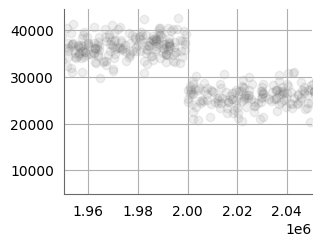

In [19]:
# Breakpoint in trend between savings_bal_lbg and annual_net_savings_lbg
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4/2, 4.8/2))
axes.scatter(clean_train_df['savings_bal_lbg'], clean_train_df['annual_net_savings_lbg'], color='dimgray', alpha=0.1)
axes.tick_params(bottom=False, left=False)
axes.grid(True)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_xlim(1.95e6, 2.05e6);

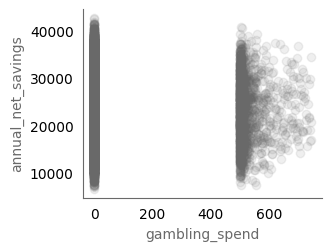

In [20]:
# Replot gambling_spend vs. annual_net_savings

# Filter condition
percentile_lower = np.percentile(clean_train_df['gambling_spend'], 75)
percentile_upper = np.percentile(clean_train_df['gambling_spend'], 99)
filter_condition = (clean_train_df['gambling_spend'] >= percentile_lower) & (
    clean_train_df['gambling_spend'] <= percentile_upper
)

# Plot
fig, axes = plt.subplots(
    nrows=1, ncols=1, sharey=True, constrained_layout=True, figsize=(6.4/2, 4.8/2)
)
axes.scatter(
    clean_train_df.loc[filter_condition, 'gambling_spend'], clean_train_df.loc[filter_condition, 'annual_net_savings_lbg'], color='dimgray', alpha=0.1
)
axes.set_xlabel('gambling_spend', fontsize=10, color='dimgray')
axes.set_ylabel('annual_net_savings', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

#### Categorical-categorical
* Chi-squared and Cramer's V indicates categorical variables are independent.

**Background**

**_1) Pearson's chi-squared test_**

1. What it Measures:

    * Goodness of fit - how well a model fits observations

    * Common application: Whether two categorical variables are <u>independent</u>.

2. Assumptions:

    * No distribution of the variables is assumed (i.e. non-parametric).

    * The data in the cells should be frequencies, or counts of cases.
  
    * The levels (or categories) of the variables are mutually exclusive.

3. Hypotheses:

   * Null hypothesis $H_0$: There is no association or independence between the two categorical variables.
  
   * Alternate hypothesis $H_1$: There is a significant association or dependence between the two categorical variables.

4. Test statistic:

    * Calculated using a contingency table

    * The test statistic is chi-squared distributed under the null hypothesis $H_0$

        $\chi^2  \sim \chi^2(k)$
    
        $ \chi^2 = \sum_i \frac{(O_i-E_i)^2}{E_i}$

        *Where $k$ is the number of degrees of freedom, $O_i$ is the observed value of interest and $E_i$ is the expected value.*

    * When testing independence, expected values are calculated assuming independence:
  
        $E_{ij}\bigl(x_iy_j\bigr) = P\bigl(X=x_i \cap Y=y_j\bigr) \times N = P\bigl(X=x_i\bigr)P\bigl(Y=y_j\bigr) \times N$
  
        $E_{ij}\bigl(x_iy_j\bigr) = \frac{R_i}{N}\frac{C_j}{N} \times N$

        $E_{ij}\bigl(x_iy_j\bigr) = \frac{R_i \times C_j}{N}$

        *Where $R_i$ and $C_j$ are the total counts in row $i$ and column $j$.*

6. P-value:
  
    * The p-value is determined using the chi-squared distribution $\chi^2(k)$
  
    * The degrees of freedom $k$ is given by:
  
        $k=\bigl(r-1\bigr)\bigl(c-1\bigr)$

        *Where $r$ is the number of rows and $c$ is the number of columns.*

        *Note: The rationale behind subtracting 1 from both the number of rows and columns is linked to the idea that when analyzing the association between two categorical variables, the last category for each variable can be predicted once the frequencies of the other categories are known. Therefore, the degrees of freedom reflect the "independent" comparisons that can be made.*

    * If the p-value of the test statistic is below the chosen threshold, there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of the contingency table.
  
[Source](https://en.wikipedia.org/wiki/Chi-squared_test)

**_2) Cramer's V_**

1. What it Measures:

    * An effect size measurement for the chi-square test of independence.

        *Note: For smaller sample sizes or tables with a small number of cells, alternatives like the phi coefficient may be more suitable.*

    * It measures strength of <u>association</u> between two categorical variables
  
2. Interpretation:

    $V \in [0, 1]$

    *A value close to $0$ indicates a weak association, while a value close to $1$ indicates a strong association.*

3. Examples:

    $V=0:$ No association between the two categorical variables

    *Note: The observed values are no different to that expected.*

    |        | Category 1 | Category 2 |
    |--------|------------|------------|
    | Group A| 10         | 10         |
    | Group B| 10         | 10         |

    $V=1:$ Perfect association between the two categorical variables

    *Note: The distribution of one variable perfectly determines the distribution of the other.*

    |         | Category 1 | Category 2 |
    |---------|------------|------------|
    | Group A | 20         | 0          |
    | Group B | 0          | 20         |

[Source](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

In [21]:
def cramers_v(vars, df):
    """
    Compute cramers v between categorical variables for a given dataframe df.
    This calculation assumes each dataframe element consists of a (var1, var2) tuple.
    """
    var1, var2 = vars
    contigency_table = pd.crosstab(
        index=df[var1], columns=df[var2]
    )
    X2 = chi2_contingency(
        contigency_table
    )
    chi_stat = X2[0]
    N = len(df)
    min_dim = (min(contigency_table.shape)-1)
    return np.sqrt((chi_stat/N) / min_dim)

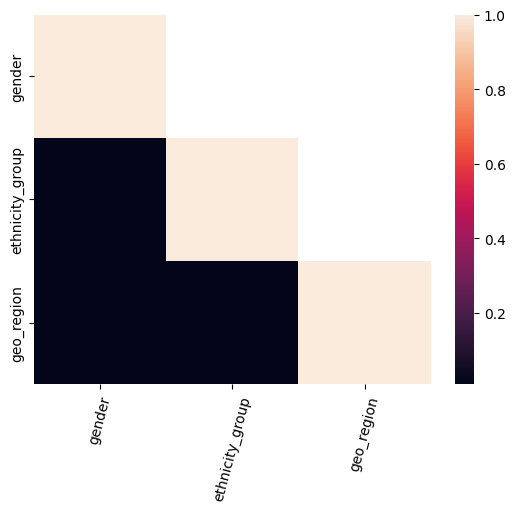

In [22]:
nominal_features = ['gender', 'ethnicity_group', 'geo_region']
cramersv_corr = pd.DataFrame(
    [[(row, col) for row in nominal_features] for col in nominal_features], columns=nominal_features, index=nominal_features
)
cramersv_corr = cramersv_corr.map(
    lambda x: cramers_v(x, df=clean_train_df)
)
cat_mask = np.tril(cramersv_corr) == 0

fig, axes = plt.subplots(
    figsize=(6.4, 4.8)
)
sns.heatmap(
    cramersv_corr, mask=cat_mask, ax=axes
)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

#### Categorical-continuous
* Spearman's rank indicates 'cust_unique_id' is not correlated with any other variable.

* Annual net savings appears to be higher for White British individuals.

**Background**

**_1) Point biserial correlation coefficient_**

1. What it measures?

    * Measures the direction & strength of <u>correlation</u> between a continuous variable and a dichotomous variable.
  
    * Equivalent to the Pearson correlation coefficient with dichotomous $Y$
  
        $r_{pb} \in [-1, 1]$
    
        *A value close to $-1$ indicates a strong negative correlation, while a value close to $1$ indicates a strong positive correlation. A value of $0$ indicates no correlation.*
  
3. Assumptions:

   * The continuous variable is normally distributed.
     
   * The continuous variable is homoscedastic.
  
       *Note: Homoscedastic means homogeneity of variances. I.e. The variance of the continuous variable must be equal or similar in the different groups being compared.*

[Source](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient)

**_2) One way ANOVA (Analysis of Variance) & Eta-squared_**

* Together these can be used to estimate the strength of <u>association</u>. Namely the variance of the continuous variable, which can be explained through the categorical variable.

**_One way ANOVA_**

1. What it Measures:

    * Whether there are statistically significant differences among the means of three or more groups.

2. Assumptions:

    * Normality: Dependent variable is approximately normally distributed within each group.
      
    * Homogeneity of Variances: Variances of the dependent variable are approximately equal across groups.
      
    * Independence: Observations are independent.

3. Hypotheses:

    * Null Hypothesis ($H_0$): The means of all groups are equal.
      
    * Alternative Hypothesis ($H_1$): At least one group mean is different.

4. Test Statistic:

    * The test statistic is the F-statistic, which follows an F-distribution
  
      $F = \frac{MS_{between}}{MS_{within}}$

      *Where $MS_{between}$ is Mean Square Between Groups and $MS_{between}$ is Mean Square Within Groups.*

5. Steps:

    * The test statistic is calculated.

    * If the p-value of the test statistic is below the chosen threshold, there is a statistically significant difference among the group means.
  
[Source](https://en.wikipedia.org/wiki/One-way_analysis_of_variance)

**_Eta-squared (η²)_**

1. What it Measures:

    * An effect size measurement for one-way ANOVA.

    * Eta-squared (η²) measures the proportion of total variance in the dependent variable that is attributable to the variance between groups in ANOVA.

2. Interpretation:

    $\eta^2 \in [0, 1]$

    *A value close to $0$ indicates a weak association, while a value close to $1$ indicates a strong association.*

[Source](https://en.wikiversity.org/wiki/Eta-squared)

In [23]:
continuous_features = clean_train_df.select_dtypes('number').columns
correlation_list = []
for col in continuous_features:
    spearman_corr, _ = spearmanr(
        clean_train_df['cust_unique_id'], clean_train_df[col]
    )
    correlation_list.append(
        ('cust_unique_id', col, spearman_corr)
    )

correlation_list = sorted(
    correlation_list, key=lambda x: np.abs(x[2]), reverse=True
)
correlation_df = pd.DataFrame(
    correlation_list, columns=['variable_1', 'variable_2', 'correlation']
)
correlation_df

variable_1              variable_2  correlation
0   cust_unique_id           housing_spend     0.013548
1   cust_unique_id            other_income     0.010455
2   cust_unique_id              net_salary     0.009871
3   cust_unique_id            credit_score     0.009423
4   cust_unique_id         observed_income     0.008744
5   cust_unique_id  annual_net_savings_lbg     0.007749
6   cust_unique_id        observed_surplus     0.006567
7   cust_unique_id         savings_bal_lbg     0.003651
8   cust_unique_id         childcare_spend     0.002141
9   cust_unique_id                     age     0.001335
10  cust_unique_id          gambling_spend    -0.000921

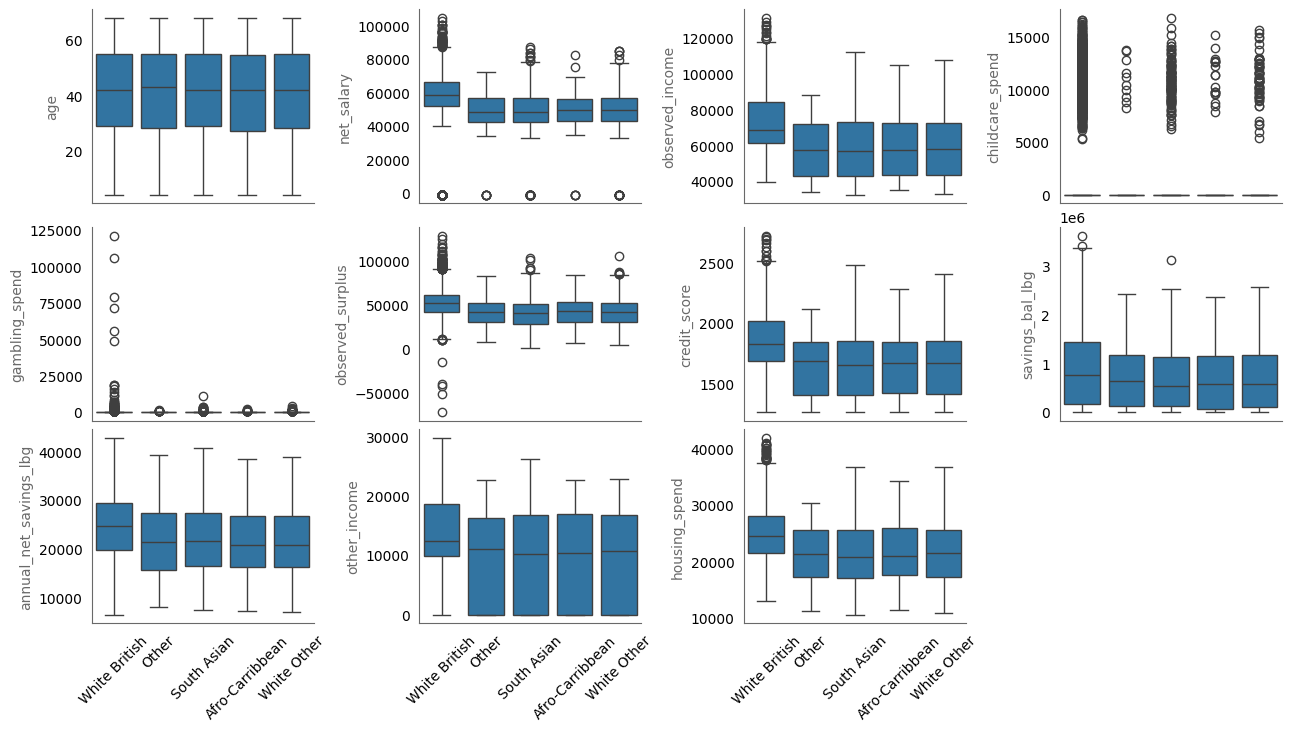

In [24]:
# Boxplot: Ethnicity vs Continuous variables
fig, axes = plt.subplots(
    nrows=3, ncols=4, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8*1.5)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes('number'):
    sns.boxplot(x='ethnicity_group', y=col, data=clean_train_df, ax=axes[i])
    axes[i].set_ylabel(col, fontsize=10, color='dimgray')
    axes[i].set_xlabel('')
    axes[i].set_xticks(range(len(clean_train_df['ethnicity_group'].unique())))
    axes[i].set_xticklabels(
        clean_train_df['ethnicity_group'].unique(), rotation=45)
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

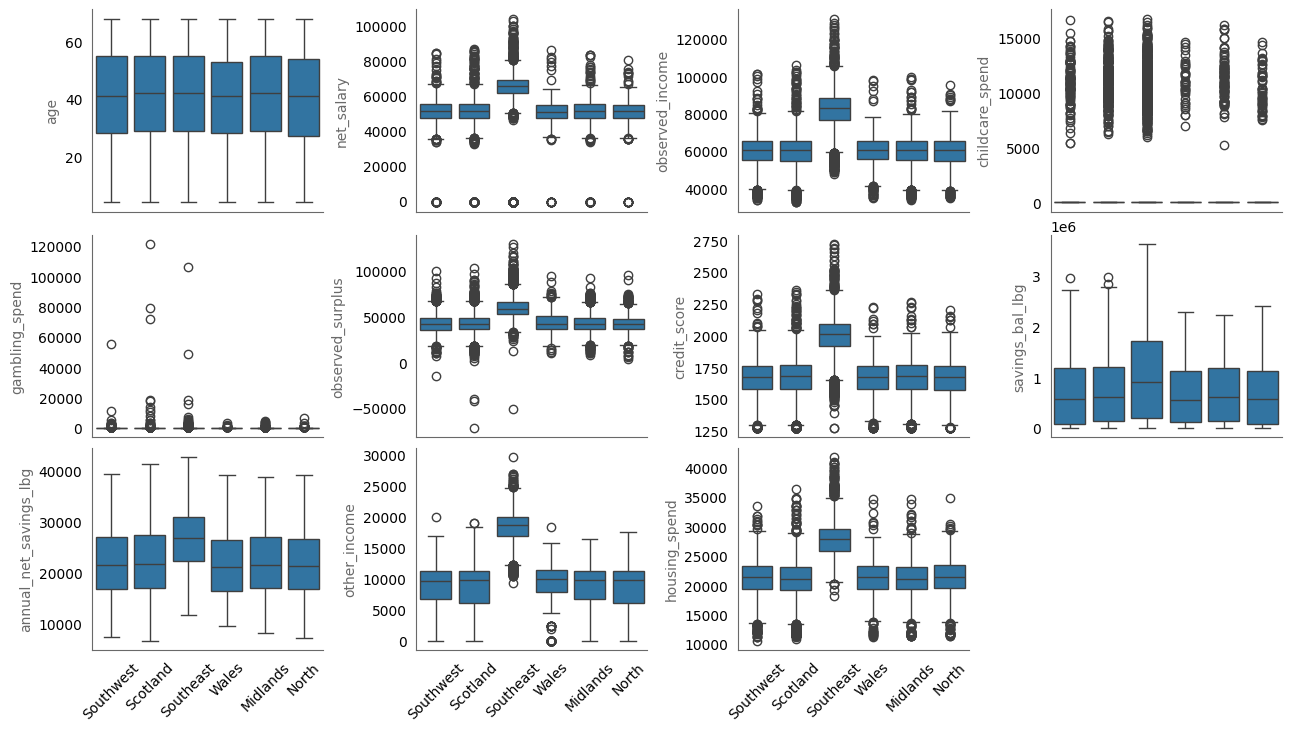

In [25]:
# Boxplot: Region vs Continuous variables
fig, axes = plt.subplots(
    nrows=3, ncols=4, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8*1.5)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes('number'):
    sns.boxplot(x='geo_region', y=col, data=clean_train_df, ax=axes[i])
    axes[i].set_ylabel(col, fontsize=10, color='dimgray')
    axes[i].set_xlabel('')
    axes[i].set_xticks(range(len(clean_train_df['geo_region'].unique())))
    axes[i].set_xticklabels(clean_train_df['geo_region'].unique(), rotation=45)
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

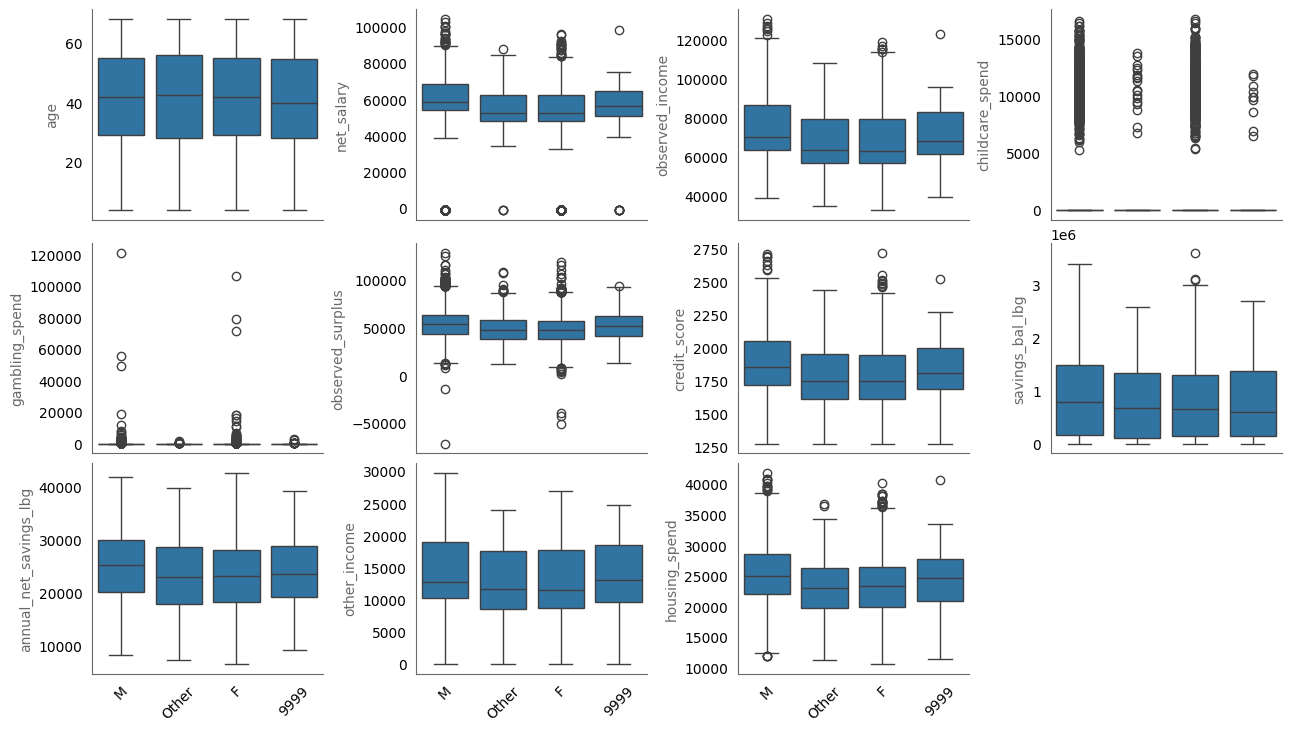

In [26]:
# Boxplot: Gender vs Continuous variables
fig, axes = plt.subplots(
    nrows=3, ncols=4, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8*1.5)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes('number'):
    sns.boxplot(x='gender', y=col, data=clean_train_df, ax=axes[i])
    axes[i].set_ylabel(col, fontsize=10, color='dimgray')
    axes[i].set_xticks(range(len(clean_train_df['gender'].unique())))
    axes[i].set_xticklabels(clean_train_df['gender'].unique(), rotation=45)
    axes[i].set_xlabel('')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

------------------

# Part 3

_"Build statistical model(s) – also known as econometric model(s) – to explain how a set of explanatory variables each affect annual net savings. Comment on the results. Which explanatory variables have robust statistically significant effects in your model(s)? Do these results make sense?"_

## Summary

**Model development**

The task of explaining annual savings is approached as two distinct tasks. 

1. Ordinary least squares
   
    An ordinary least squares (OLS) model was constructed to predict savings above zero. Key steps are outlined below:

    - Breakpoint dummy variables and corresponding interaction terms were incorporated for age, aiming to capture the observed non-linearity in part 2 of the analysis.
      
    - Similarly, a breakpoint dummy variable and its corresponding interaction term were added for 'savings_bal_lbg' to account for the breakpoint identified in part 2.
      
    - Feature selection was carried out by initially fitting the model with all features and subsequently eliminating those deemed insignificant, with a p-value below 0.05.
      
    - To ensure the validity of interpretation, normality of residuals was confirmed prior to further analysis.

2. Logistic regression

    A logistic regression model was formulated to explain the probability of zero savings. Key steps are outlined below:

    - All predictive features were scaled as logistic regression is solved via optimisation.

    - A 5-fold cross-validation grid search was used to optimise regularisation and Synthetic Minority Over-sampling Technique (SMOTE) parameters.
    
        Note: L1 regularisation was used to achieve feature selection, and SMOTE was applied to generate a balanced class distribution in the dataset.

**Model interpretation**

* Unfortunately, the predictive performance of logistic regression was poor. It was decided interpreting the model would be unwise given the poor fit.

* The coefficients for OLS were interpreted as follows:

    1. **const:** It suggests that when all predictor variables are zero, the expected annual net savings is approximately -5655.25.
         
    2. **credit_score:** For each one-unit increase in credit score, the expected annual net savings is estimated to increase by 14.01 units.
       
    3. **housing_spend:** For each one-unit increase in housing spending, the expected annual net savings is estimated to increase by 0.0143 units.
       
    4. **age_dummy_2:** It suggests that, compared to the reference group (ages 1-24 and 55+), the expected annual net savings is lower on average by 3013.94 units for individuals between 25-54.
        
    5. **age_dummy_3:** It suggests that, compared to the reference group (ages 1-54), the expected annual net savings is lower on average by 3385.37 units for individuals aged 55 years and above.
 
    6. **age:**
       
        * The interaction terms must be considered when considering the coefficient for age.
  
        * For individuals less than 25 years in age, for each one-unit increase in age, the expected annual net savings is estimated to increase by 0.84 units (38.45-37.61) compared to the reference group (ages 25+).
      
        * For individuals between 25 years and 54 years of age, for each one-unit increase in age, the expected annual net savings is estimated to increase by 7.75 units (38.45-30.7) compared to the reference group (ages 1-24 and 55+).

        * For individuals above 55 years of age, for each one-unit increase in age, the expected annual net savings is estimated to increase by -6.35 units (38.45-44.8) compared to the reference group (ages <55).

    7. **savings_bal_lbg:**

        * The interaction term must be considered when considering the coefficient for 'savings_bal_lbg'.
          
        * For each unit increase in savings balance, the expected annual net savings is estimated to increase by 0.04 units (0.0060-0.0056).
      
          Note: It remains unclear why this breakpoint occurs. Further investigations are necessary.
        
    9. **zero_savings_bal:** It suggests that, compared to the reference group (individuals with savings at the beginnning of the year), the expected annual net savings is on average lower by 1425.66 units for individuals with no savings at the beginning of the year.
        
    10. **ethnicity_group_South Asian:** It suggests that, compared to the reference group, the expected annual net savings is higher by 775.42 units for individuals in the South Asian ethnicity group.

        Note: Earlier analysis of pairwise associations suggested annual savings were highest for White British individuals.

## Ordinary least squares

### Background

#### Assumptions

**1) Linear data generating process**

* The regression model is linear in the coefficients (i.e. all raised to the power of one)

    $Y = b_0 + b_1X_1 + b_2X_2 + ... + b_pX_p + e$

    *Note: Linear regression models can model curvature by including nonlinear variables (e.g. $X_i^2$)*

**2) Error**

Given any value of the explanatory variables:

    a) All independent variables are uncorrelated with the error term (AKA Exogeneity)

        Note: It leads to bias in the coefficient estimates. It can indicate a missing variable or measurement error. 

    b) The error term has a mean of zero

    c) The error term has constant variance (aka homoskedasticity)

    d) The error terms are not correlated across observations (i.e. no autocorrelation)

        Note: Autocorrelation indicates non-random error.

    e) The residuals are normally distributed (OPTIONAL)

        Note: Required for unbiased estimates of standard error, p-values, confidence intervals etc.

**3) Multicollinearity**

    a) No independent variable is a perfect linear function of other explanatory variables.

    Note: Ordinary least squares cannot distinguish one variable from the other when they are perfectly correlated. This prevents the model fitting and will result in an error message. Imperfect but strong correlation (i.e. multicollinearity) leads to unstable coefficient estimates.

---------------------

#### Implementation

* OLS is solved by minimises the sum of squared residuals:

  $\sum_{i=1}^n (y_i-\hat{y}_i)^2$

    *Where n = no. of records*

* Two methods:

    1. ***Algebraically*** via the below closed form solution.
    
        $ W = (XX^T)^{-1}Xy^T $

        *Where $X$ is the design matrix ($n$ rows and $p+1$ columns)*
  
    3. ***Iteratively*** using the gradient descent algorithm to estimate parameter coefficients.
 
**Properties**

* The OLS estimate of $b_i$ is unbiased.

* If models are repeatedly fit on resampled data, the average of these estimates would be close to the true value

    $\mathbb{E}\bigl[\hat{b_i}\bigr] = b_i$


---------------------

#### Interpretation

**_Constant term $b_0$_**

* The mean value of $Y$ when all predictor variables are set to $0$.

* Without knowling the true underlying model, it is not worth interpreting

    *Note: It's inclusion leads to unbiased estimates as the mean of the residuals becomes equal to $0$*

**_Variable coefficients_**

Sometimes log transformed variables meet the assumptions above.

1. Linear-linear model

    * The change in the expected value of $Y$ is equal to the change in $X_i$ multiplied by $b_i$

2. Log-linear model

    $log(\hat{Y}) = b_0 + b_1X_i$

    * A unit increase in $X_i$ yields a $(100 \times b_0)\%$ change in $Y$

3. Linear-log model

    $\hat{Y} = b_0 + b_1log(X_i)$

    * A unit increase in $X_i$ yields a $b_i/100$ increase in $Y$

4. Log-log model

    $log(\hat{Y}) = b_0 + b_1log(X_i)$

    * A $1\%$ increase in $X_i$ leads to a $b_i\%$ change in $Y$
  
**_Interaction terms/dummy variables_**

* Enable piecewise linear regression when the data follows a different linear trend over time

    Example:
    
    $Y = b_0 + b_1X_1 + b_2X_2 + b_3X_1X_2$
    
    *Where $X_2$ is a dummy variable*
    
    * When $X_2=1$:
    
        $Y = (b_0 + b_2) + (b_1 + b_3)X_2$
    
    * When $X_2=0$:
    
        $Y = b_0 + b_1X_1$
    
    * Interpretation:
    
        When $X_2=1$, there is a shift in the average value of $Y$ by $b_2$ and a change in the rate of change of $Y$ w.r.t $X_2$ by $b_3$

**_Confidence interval_**

    "Confidence intervals define the interval which has a 0.95 probability of containing the true parameter"

    "It represents the long-run % of sample confidence intervals which will contain the true parameter"

* OLS gives a point estimate of $b_i$

* This will vary from sample-to-sample

* The confidence interval quantifies the uncertainty of the estimate

How?

* Compute critical t statistic value for the given confidence level

  *This will depend on the degrees of freedom*

* Estimate standard error
 
* Compute margin of error

  $Margin = S.E \times t_{critical}$

* Construct confidence interval

    $CI = \hat{b_i} \pm margin$

**_Standard error_**

* We don't know the population variance for $b_i$

* Estimate the SE of the sampling distribution for $b_i$:

    $SE(b_i) = \sqrt{\sigma^2Var(b_i)}$

    *Where $\sigma$ is the standard deviation of the residuals which depends on $dof_{residual}$*

**_T-statistic_**

* A large absolute value of the t-statistic suggests $\hat{b_i}$ is far from $0$.

    $t=\frac{\hat{b_i}}{SE(b_i)}$

  *Note: $t$ depends on the $dof_{residual}$*

**_P-value_**

* Is $b_i$ significantly different from $0$?

    $H_0: b_1=0$

    $H_1: b_1\neq0$

* Statistical significance is determined using the t-statistic via the corresponding t-distribution

* Gives the probability of a result at least as extreme under the null model:

    $p-value = P(|b_i| > |b| ; H_0)$

* Reject $H_0$ based on pre-determined significance level $\alpha$

--------------------

#### Covariance type

    "Standard errors assume the covariance matrix of the errors is correctly specified"

* Non-robust *-> Assumes homoscedasticity (across all variables)*

* Robust *-> Allows heteroscedasticity*

--------------------

#### Degrees of freedom

**_1. What are degrees of freedom?_**

* The *dof* for a parameter/statistic estimate are equal to the number of input values that are free to vary

* When a statistic is estimated using another estimate, constraints on variabiltiy must be aknowledged to produce unbiased estimates

**_2. Multiple linear regression_**

* Degrees of freedom associated with estimated parameters:

  $df_{model} = p + 1$

  *Where p is the number of explanatory variables* 

* Degrees of freedom associated with residuals:
    
  $df_{residual} = n - df_{model} = n- p - 1$

    *Model parameters are estimates and therefore introduce constraints on variability of residuals*

* Underdetermined system:

    - When the number of observations $n$ is less than the number of parameters to be estimated $p$:
 
        $df_{residual}<0$

    - Infinite number of solutions
 
      *Note: It is a system of linear equations where there are fewer equations than unknowns*

    - Dimensionality reduction or ridge/lasso regression may stabilise estimates.

--------------------

#### Goodness of fit

**_1. Pre-requisites_**
    
$RSS = \sum_{i=1}^n (y_i - \hat{y})^2$ *-> quantifies unexplained variability*

$TSS = \sum_{i=1}^n (y_i - \bar{y})^2$ *-> quantifies variability in dependent variable*

**_2. R-squared_**

$R^2 = 1 - \frac{RSS}{TSS}$

* $R^2=0$ *-> model predicts $\bar{y}$*

* $R^2=1$ *-> model predicts observed values*

* $R^2=0.5$ *-> 50% of variability captured*
   
**_3. Adjusted R-squared_**
   
* $R^2$ increases when you add extra explanatory variables because $RSS$ decreases when the model has more flexibility.

* Penalises unnecessary variables in the model   

    $R^2_{adjusted} = 1 - \frac{RSS/df_{res}}{TSS/df_{model}}$

**_4. Log-likelihood_**

* In OLS, we use it for a probabilistic interpretation of goodness of fit (higher=better).

* Likelihood function gives the joint probability of observed data viewed as a function of model parameters:

    $L(\theta) = P_{X_1,..X_n}(x_1,...,x_n; \theta)$

    $L(\theta) = f_{X_1,..X_n}(x_1,...,x_n; \theta)$

    *Note: MLE estimate of $\theta$ gives the value of $\theta$ that maximises $L(\theta)$*

* By assuming all records are i.i.d, the joint probability distribution can be estimated using marginal distributions:

    $L(\theta) = \prod_{i=1}^n f_{X_i}(x_i; \theta)$

    $LL(\theta) = \sum_{i=1}^n log f_{X_i}(x_i; \theta)$

    *If residuals are normally distributed with mean $0$ and constant variance, the normal PDF is used for each instance.*

**_5. AIC_**

* Measures goodness of fit whilst penalizing the model for the number of parameters.

    $AIC = 2P + n \times log (RSS/n)$

    *Where $RSS$ is the residual sum of squares, $p$ is the number of parameters and $n$ is the number of datapoints.*

* Lower is better - it's negative when $RSS/n<0$

**_6. BIC (Bayesian information criterion)_**

* Measures goodness of fit whilst penalizing the model for the number of parameters.

    $BIC = k \times ln(n) - 2 ln(\hat{L})$

    *Where $L$ is the maximum likelihood, $k$ is the number of parameters and $n$ is the number of datapoints.*

* Lower is better

* The penalty is stronger than AIC

--------------------

#### Significance metrics

**_1. Pre-requisites_**

$RSS = \sum_{i=1}^n (y_i - \hat{y})^2$ *-> quantifies unexplained variability*

$ESS = \sum_{i=1}^n (\hat{y_i} - \bar{y})^2$ *-> quantifies explained variability*

$TSS = RSS + ESS$ *->variability of the dependent variable* 

**_2. F-statistic_**

* It's the ratio of the explained and unexplained variability:

    $F=\frac{ESS}{RSS}$

    * $F>1$ *-> model better than one without predictors*
  
    * $F<1$ *-> model worse than one without predictors*
  
    *Note: A model without predictors: $\hat{y}=\bar{y}$*
  
**_3. P-value (F-statistic)_**

* Tests the overall significance of the model

  $H_0:$ The model has no explanatory power -> no $b_i>0$

  $H_1:$ The model has explanatory power-> at least one $b_i>0$

* The p-value of the f-statistic is compared to a significance level $\alpha$

--------------------

#### Residual metrics

* A number of metrics are provided to assess assumptions related to residuals.

**_1. Skew & kurtosis_**

* Tests normality of residuals. A standard normal distribution has a kurtosis (tailedness) of $3$ and a skew (asymmetry) of $0$.

**_2. Durbin-watson_**

* Tests autocorrelation in the residuals. It ranges from 0 to 4, with values around 2 indicating no autocorrelation.

**_3. Jaque-Bera & prob(JB)_**

* Tests normality of residuals. The p-value is given by prob(JB). A significant result may indicate non-normality.

--------------------

#### Diagnosing multicollinearity

* Multicollinearity inflates the variances of the parameter estimates

**_1. Correlation matrix_**
    
* Large correlation coefficients in the correlation matrix of predictor variables indicate multicollinearity.

**_2. Singular design matrix $\boldsymbol{X}$_**

*"The smallest eigenvalue is 1.53e-16. This might indicate that there are strong multicollinearity problems or that the design matrix is singular."*
      
* When all columns are independent, the rank is $p+1$
  
* If multicollinearity is present, the matrix is singular *-> non-invertible -> OLS fails*

**_3. PCA_**

1. Factorising the covariance matrix gives eigenvectors

2. Eigenvectors are orthogonal directions in the feature space along which data varies

3. A principal components is formed by projecting data points onto an eigenvector

4. Eigenvalues are proportional to the variance of data along a principal component

5. By only using a subset of the principal components, dimensionality is reduced

    *Principal components are independent as eigen vectors are orthogonal*

**_a) Eigen values of the covariance matrix_**

*"The smallest eigenvalue is 1.53e-16. This might indicate that there are strong multicollinearity problems or that the design matrix is singular."*

* Each eigenvalue indicates the variance of the data along the direction of the corresponding eigenvector.

* Eigenvalues close to $0$ indicate multicollinearity:

**_b) Condition index_**

* Used to assess multicollinearity

* Utilises magnitude of variance along orthogonal eigen vectors in the feature space (as given by eigen values)

    $\text{Condition index} = \sqrt{\frac{\lambda_{max}}{\lambda_{min}}}$

    *Where $\lambda_{max}$ is the largest eigen value and $\lambda_{min}$ is the smallest.*

* Intepretation:

    $\text{Condition index} = 1:$ -> *Eigen values similar in size - no multicollinearity*

    $\text{Condition index} > 30:$ -> *Large disparity in size - multicollinearity*

--------------------

#### Outlier detection
* Outliers are points which behave differently to the rest of the data.

* We want to identify outliers which 'influence' model fitting and therefore parameters

<img src="figures/leverage_discrepancy_influence.png" align="left" width="700" />

[Source](https://tillbe.github.io/outlier-influence-identification.html)

A. **Leverage**
* A point that is highly different in its predictor behavior than the rest of the data. The x-value of a predictor is either much higher or lower than the mean of the predictor.

B. **Discrepancy**
* If a point has an unusual y-value given its x-value, it has high discrepancy. This is what is called a outlier within the regression framework.

C. **Influence**
* High leverage *or* high discrepancy is not always enough to 'influence' model parameters. The influence of a single data point is defined as its leverage multiplied by its discrepancy.

--------------------

### Feature preprocessing

* Given the non-linear relationship observed between age and annual savings, a series of dummy variables and interaction terms were constructed from the 'age' feature. These correspond to ages 1-24, 25-54 and 55+.
  
* Similarly, a breakpoint dummy variable and corresponding interaction term was included for 'savings_bal_lbg' due to the breakpoint observed when 'savings_bal_lbg' is equal to $2\times10^6$.

* Dummy variables were added to indicate zero values for the following features: 'zero_savings_bal' and 'zero_childcare_spend'.

* Multicollinearity was addressed by dropping 'net_salary', 'observed_income' and 'other_income'. 'Observed_surplus' was retained as the data dictionary indicates it contains information on all these features.

In [27]:
def preprocess_ols_features(df):
    """
    Remove selected features and apply required feature engineering steps.
    """
    # Drop selected features
    df = df.drop(['net_salary', 'observed_income', 'other_income', 'cust_unique_id', 'gambling_spend'], axis=1)

    # Add breakpoint dummy variables for age
    df['age_dummy_1'] = np.where(df['age'] < 25, 1, 0)
    df['age_dummy_2'] = np.where((df['age'] >= 25) & (df['age'] < 55), 1, 0)
    df['age_dummy_3'] = np.where(df['age'] >= 55, 1, 0)

    # Add interaction terms for age
    df['age_interaction_1'] = df['age_dummy_1'] * df['age']
    df['age_interaction_2'] = df['age_dummy_2'] * df['age']
    df['age_interaction_3'] = df['age_dummy_3'] * df['age']

    # Add breakpoint dummy variable for savings_bal_lbg
    df['savings_bal_dummy'] = np.where(df['savings_bal_lbg'] > 2e6, 1, 0)

    # Add interaction term for savings_bal_lbg
    df['savings_bal_interaction'] = df['savings_bal_dummy'] * df['savings_bal_lbg']

    # Add dummy variable for predictive features with a high proportion of zeros
    df['zero_savings_bal'] = (df['savings_bal_lbg'] == 0).astype(int)
    df['zero_childcare_spend'] = (df['childcare_spend'] == 0).astype(int)

    # Divide predictive features from target
    y_train = df['annual_net_savings_lbg']
    X_train = df.drop(['annual_net_savings_lbg'], axis=1)

    # One-hot-encode the categorical features
    for col in ['gender', 'geo_region', 'ethnicity_group']:
        X_train = pd.get_dummies(X_train, columns=[col], prefix=col, dtype='int64', drop_first=True)

    return X_train, y_train

In [28]:
# Preprocess features
X_train, y_train = preprocess_ols_features(clean_train_df)

### Feature selection

* The significance of features was assessed using a significance threshold of 0.05. All features with p-values higher than this threshold were dropped. The confidence intervals for the remaining features did not include zero.

* The final model has an R-squared of 0.923. This indicates a good fit.

In [29]:
# Fit OLS
X_train = sm.add_constant(X_train) # Stats models does not add a constant by default
model = sm.OLS(y_train, X_train)
fit_model = model.fit()
display(fit_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     annual_net_savings_lbg   R-squared:                       0.923
Model:                                OLS   Adj. R-squared:                  0.923
Method:                     Least Squares   F-statistic:                     9460.
Date:                    Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                            20:12:45   Log-Likelihood:            -1.8374e+05
No. Observations:                   20582   AIC:                         3.675e+05
Df Residuals:                       20555   BIC:                         3.678e+05
Df Model:                              26                                         
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -5905.8335    344.113    -17.162      0.000   -6580.323   -5231.344
age                              38.9081      3.634     10.708      0.000      31.786      46.031
childcare_spend                  -0.0023      0.027     -0.085      0.932      -0.056       0.051
observed_surplus                  0.0002      0.001      0.111      0.912      -0.003       0.003
credit_score                     13.8206      0.202     68.297      0.000      13.424      14.217
savings_bal_lbg                   0.0060      0.000     59.668      0.000       0.006       0.006
housing_spend                     0.0161      0.007      2.449      0.014       0.003       0.029
age_dummy_1                     181.6786    209.973      0.865      0.387    -229.886     593.243
age_dummy_2                   -2772.9118    204.795    -13.540      0.000   -3174.327   -2371.496
age_dummy_3                   -3314.6003    354.160     -9.359      0.000   -4008.782   -2620.418
age_interaction_1               -36.6091      8.398     -4.359      0.000     -53.070     -20.148
age_interaction_2                30.7304      4.492      6.841      0.000      21.926      39.535
age_interaction_3                44.7868      6.266      7.147      0.000      32.504      57.070
savings_bal_dummy               861.7508    493.576      1.746      0.081    -105.697    1829.198
savings_bal_interaction          -0.0060      0.000    -27.366      0.000      -0.006      -0.006
zero_savings_bal              -1437.0652    217.297     -6.613      0.000   -1862.985   -1011.145
zero_childcare_spend             82.4293    305.121      0.270      0.787    -515.632     680.490
gender_F                        121.1992    117.919      1.028      0.304    -109.931     352.329
gender_M                        137.9946    118.087      1.169      0.243     -93.466     369.455
gender_Other                     63.7581    148.126      0.430      0.667    -226.581     354.098
geo_region_North                 96.4326     76.750      1.256      0.209     -54.004     246.870
geo_region_Scotland              86.8455     47.894      1.813      0.070      -7.031     180.722
geo_region_Southeast             98.5947     76.569      1.288      0.198     -51.487     248.676
geo_region_Southwest             63.6158     57.810      1.100      0.271     -49.697     176.929
geo_region_Wales                 -2.8250     84.684     -0.033      0.973    -168.812     163.162
ethnicity_group_Other          -134.6936    152.389     -0.884      0.377    -433.389     164.001
ethnicity_group_South Asian     788.9759     97.710      8.075      0.000     597.457     980.495
ethnicity_group_White British    39.6029     94.616      0.419      0.676    -145.851     225.057
e

In [30]:
# Drop features with insignificant p-values
features_to_drop = ['childcare_spend', 'observed_surplus', 'age_dummy_1', 'savings_bal_dummy', 'zero_childcare_spend',
                    'gender_F', 'gender_M', 'gender_Other', 'geo_region_North', 'geo_region_Scotland', 'geo_region_Southeast',
                    'geo_region_Southwest', 'geo_region_Wales', 'ethnicity_group_Other', 'ethnicity_group_White British',
                    'ethnicity_group_White Other']
X_train = X_train.drop(features_to_drop, axis=1)

# Refit OLS
X_train = sm.add_constant(X_train) # Stats models does not add a constant by default
model = sm.OLS(y_train, X_train)
fit_model = model.fit()
display(fit_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     annual_net_savings_lbg   R-squared:                       0.923
Model:                                OLS   Adj. R-squared:                  0.923
Method:                     Least Squares   F-statistic:                 2.236e+04
Date:                    Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                            20:12:45   Log-Likelihood:            -1.8375e+05
No. Observations:                   20582   AIC:                         3.675e+05
Df Residuals:                       20570   BIC:                         3.676e+05
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -5655.2466    197.592    -28.621      0.000   -6042.543   -5267.950
age                            38.4487      3.602     10.674      0.000      31.388      45.509
credit_score                   14.0053      0.127    110.051      0.000      13.756      14.255
savings_bal_lbg                 0.0060   9.86e-05     60.725      0.000       0.006       0.006
housing_spend                   0.0143      0.005      2.744      0.006       0.004       0.025
age_dummy_2                 -3013.9358    263.225    -11.450      0.000   -3529.878   -2497.994
age_dummy_3                 -3385.3715    480.036     -7.052      0.000   -4326.280   -2444.463
age_interaction_1             -37.6113      8.370     -4.494      0.000     -54.016     -21.206
age_interaction_2              32.3932      4.383      7.390      0.000      23.801      40.985
age_interaction_3              43.6668      6.201      7.042      0.000      31.512      55.821
savings_bal_interaction        -0.0056   3.35e-05   -168.063      0.000      -0.006      -0.006
zero_savings_bal            -1425.6567    215.452     -6.617      0.000   -1847.960   -1003.353
ethnicity_group_South Asian   775.4244     46.096     16.822      0.000     685.072     865.776
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.840
Skew:                          -0.015   Prob(JB):                        0.657
Kurtosis:                       2.994   Cond. No.                     2.32e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.45e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Evaluation

* A slight linear trend is observed between residuals and observed annual savings. Analysis of residuals versus observed feature values does not indicate any clear potential for improvements.
  
* Given the residuals are approximately normal, the coefficients can be interpreted.

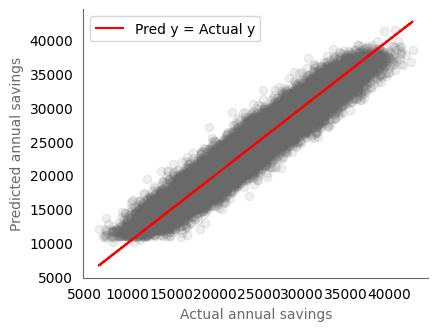

In [31]:
# Prediction diagnostics
y_pred = fit_model.predict(X_train)

fig, axes = plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5)
)
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(
    y_train, y_pred, color='dimgray', alpha=0.1
)
axes.plot(
    y_train, y_train, color='red', label='Pred y = Actual y'
)
axes.set_xlabel('Actual annual savings', fontsize=10, color='dimgray')
axes.set_ylabel('Predicted annual savings', fontsize=10, color='dimgray')
axes.legend();

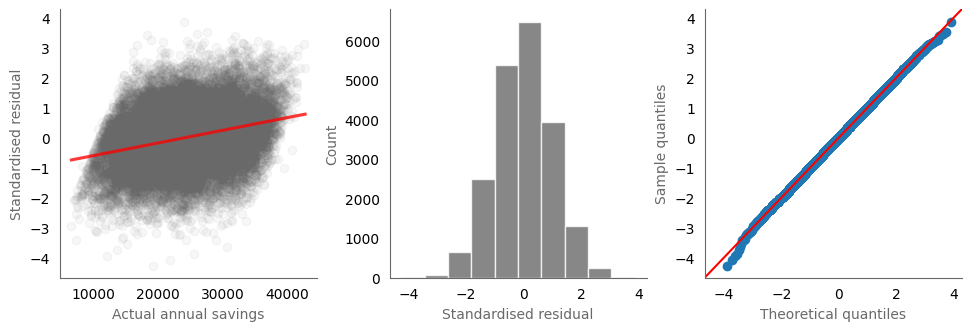

In [32]:
# Residual diagnostics
standardised_residuals = fit_model.resid / \
    fit_model.resid.std()

fig, axes = plt.subplots(
    nrows=1, ncols=3, constrained_layout=True, figsize=(6.4*1.5, 4.8/1.5)
)
axes = axes.flatten()

# Plot standardised residuals vs. observed values
sns.regplot(
    x=y_train, y=standardised_residuals, line_kws={'color': 'red', 'alpha': 0.75}, scatter_kws={'color': 'dimgray', 'alpha': 0.05}, ax=axes[0]
)
axes[0].set_xlabel('Actual annual savings', fontsize=10, color='dimgray')
axes[0].set_ylabel('Standardised residual', fontsize=10, color='dimgray')

# Plot histogram for standardised residuals
axes[1].hist(
    standardised_residuals, color='dimgray', alpha=0.8, edgecolor="white"
)
axes[1].set_xlabel('Standardised residual', fontsize=10, color='dimgray')
axes[1].set_ylabel('Count', fontsize=10, color='dimgray')

# Plot q-q plot for standardised residuals
sm.qqplot(
    standardised_residuals, line='45', ax=axes[2]
)
axes[2].set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes[2].set_ylabel('Sample quantiles', fontsize=10, color='dimgray');

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

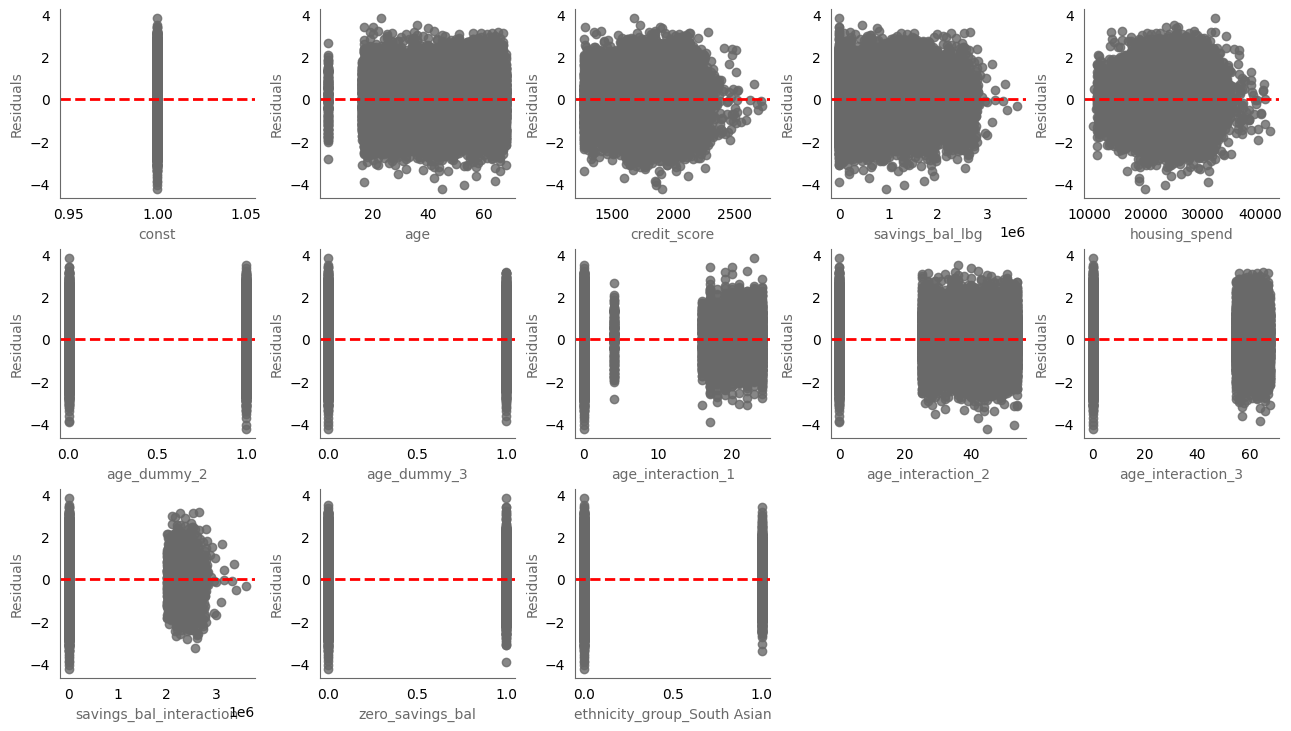

In [33]:
# Plot residuals vs predictor variables
fig, axes = plt.subplots(
    nrows=3, ncols=5, constrained_layout=True, figsize=(6.4*2, 4.8*1.5)
)
i = 0
axes = axes.flatten()
for col in X_train.columns:
    axes[i].scatter(
        X_train[col], standardised_residuals, color='dimgray', alpha=0.8
    )
    axes[i].axhline(
        y=0, color='r', linestyle='--', linewidth=2
    )
    axes[i].set_ylabel('Residuals', fontsize=10, color='dimgray')
    axes[i].set_xlabel(col, fontsize=10, color='dimgray')
    i += 1
    
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

fig.delaxes(axes[13])
fig.delaxes(axes[14])

## Logistic regression

### Background

#### Properties

* For a single data point $(\boldsymbol{x_i}, y_i)$, logistic regression models:

    $P(Y=y_i | X = \boldsymbol{x_i})$

* It's relative simplicity makes it a high-bias and low-variance model

* It finds a linear boundary based on the log-odds (AKA logit function):

    $log\bigl(odds\bigr) = \theta^T\boldsymbol{x}$

    $log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}\bigr) = \theta^T\boldsymbol{x}$

---------------------

#### Assumptions

1. Linear relationship between log-odds (AKA logit) of the dependent variable and the independent variables

2. Independent observations

3. No perfect multicollinearity

    Note:  When features are highly correlated, the coefficients won't be as accurate (this can be addressed via regularisation, removal of features...)

4. No strongly influential outliers

5. No correlation between residuals and independent variables

6. Large sample size

---------------------

#### Implementation

**Log-odds**

* Logistic regression is a linear model for the log-odds (AKA logit function):

    $log\bigl(odds\bigr) = \theta^T\boldsymbol{x}$

    $log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}\bigr) = \theta^T\boldsymbol{x}$

**Sigmoid function:**

* The sigmoid function, also known as the logistic function, is used to map log-odds to a probability

    $\forall z \in R$, $\sigma(z) \in [0,1]$

    $\sigma(z)=\frac{1}{1+exp-z}$

* It outputs numbers between $0$ and $1$. At input $0$, it outputs $0.5$.

    <img src="figures/sigmoid_func.png" align="center" width="300" />

**Optimisation**

**_Gradient descent_**

* There is no analytical solution, we cannot set $\frac{dLL(\theta)}{d\theta}=0$ and solve for $\theta$

* Gradient descent is used to optimise the *negative* log-likelihood function $-LL(\theta)$

     $\hat{\theta}_{ML} = \underset{\theta}{\operatorname{argmin}} -LL(\theta)$

**_Log-likelihood function_**

* The likelihood function $L(\theta)$ is the joint probability of the $n$ observed data points (viewed as a function of the parameters of the model):

    $L(\theta) = P(Y=\boldsymbol{y} | \boldsymbol{X}; \theta)$

    *Where $\boldsymbol{y} \in \mathbb{R}^n$ and $\boldsymbol{X} \in \mathbb{R}^{d \times n}$*

* Assuming i.i.d samples:

    $L(\theta) = \prod_{i=1}^n p(y_i | \boldsymbol{x_i}; \theta)$

    *Where $y_i \in \{0, 1\}$ and $\boldsymbol{x_i} \in \mathbb{R}^d$*

* Add the Bernoulli PMF & the logistic function:

    $L(\theta) = \prod_{i=1}^n p(y_i | \boldsymbol{x_i}; \theta)^{y_i}(1- p(y_i | \boldsymbol{x_i}; \theta))^{1-y_i}$

    $L(\theta) = \prod_{i=1}^n \sigma(\theta^T\boldsymbol{x_i})^{y_i}(1- \sigma(\theta^T\boldsymbol{x_i}))^{1-y_i}$

* Log-likelihood function $LL(\theta)$ is easier to optimise:

    $LL(\theta) = \sum_{i=1}^n y_i log\bigl[\sigma(\theta^T\boldsymbol{x_i})\bigr] + (1-y_i)log\bigl[1- \sigma(\theta^T\boldsymbol{x_i})\bigr]$

---------------------

#### Regularisation

* An additional term is added to the objective function so the model has to minimise negative log-likelihood *and* parameter weights

* This controls the complexity of models and avoids overfitting.

**_Implications_**

* Regularisation results in biased estimates of coefficients

* Coefficients reflect the relationship between the independent variables and the dependent variable *after regularisation*

* Implication:

    - Absolute magnitudes does not directly represent variable importance
      
    - It's difficult to compare models with a different magnitude regularization parameter

**_L1-regularisation_**

* The L1-norm is used to penalise model complexity

* The L1 term is a function of the number and size of the coefficients:

    $ ||W||_1 = \sum_{j=1}^d |w_j| $

    *Where, W is the d-dimensional vector of model parameters (i.e. weights), which includes a dummy variable x<sub>0</sub>=1 for the y-intercept.*

*Properties:*

* In practice regularisation is achieved by keeping the magnitude of the weight vector below a threshold (e.g. 1)

    $\sum_{j=1}^d |w_j| \leq 1 $

    E.g. $|w_1| + |w_2| < 1$

* The area in which the optimal weight vector resides will therefore take the shape of a diamond centred on the origin

    <img src="figures/l1_l2_constraint.png" align="center" width="250" /> <img src="figures/l1_surface.png" align="center" width="350" />

* If gradient descent is used to optimise weights, L1 is more likely to to reduce coefficients to zero than L2 regularisation.

* Why? The gradient is constant even as weights approach zero in magnitude.

* L1 therefore tends to produce sparse solutions, which is useful for feature selection.

**_L2-regularisation_**

* The *squared* L2-norm is used to penalise model complexity

* The L2 term is a function of the number and size of the coefficients. It is equivalent to Euclidian distance:

    $ ||W||_2 = \sqrt{\sum_{j=1}^d w_j^2} $
    
    *Where, W is the d-dimensional vector of model parameters (i.e. weights), which includes a dummy variable x<sub>0</sub>=1 for the y-intercept.*

*Properties:*

* The L2-norm squares the individual model parameters. This means large weights are much more influential than smaller weights. Compared to L1 regularisation, L2 therefore prioritises minimising larger weights

* In practice regularisation is achieved by keeping the magnitude of the weight vector below a threshold (e.g. 1)

    $\sum_{j=1}^d w_j^2 \leq 1 $

    E.g. $|w_1|^2 + |w_2|^2 < 1$

* The area in which the optimal weight vector resides will therefore take the shape of a circle centred on the origin

    <img src="figures/l1_l2_constraint.png" align="center" width="250" /> <img src="figures/l2_surface.png" align="center" width="350" />

* If gradient descent is used to optimise weights, L2 is less likely to to reduce coefficients to zero than L1 regularisation.

* Why? The cost surface is smoother. Also, the gradient decreases as weights approach zero in magnitude. This slows the rate at which a weight decreases in value. 

* L2 therefore tends lead to weights with similar sizes. Although weights can get very very small, L2 is less likely to reduce coefficients to zero.

---------------------

#### Interpretation

* Logistic regression is a linear model for the log-odds.
  
* Parameter weights do not influence the probability linearly.

**_Constant term $\theta_0$_**

* The intercept $\theta_0$ is the the log-odds of the outcome when all predictors other than $x_0$ are at $0$:

    $log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{0})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{0})}\bigr) = \theta_0x_0 = \theta_0$

    *Note: $x_0$ is always set to $1$*

* This can be converted to a probability using the logistic function:

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{0}) = \sigma(\theta_0)=\frac{1}{1+exp(-\theta_0)}$

**_Variable coefficients_**

1. Continuous variables:

    * A change in feature $x_j$ by one unit increases the log odds by $\theta_j$:
    
        $log\bigl(\frac{odds_{x_j+1}}{odds_{x_j}}\bigr) = \theta_j$
    
    * A change in feature $x_j$ by one unit increases the odds by by $exp\bigl(\theta_j\bigr)$:
    
        $\frac{odds_{x_j+1}}{odds_{x_j}} = exp\bigl(\theta_j\bigr)$ 

2. Dummy variables

    * When feature $x_j=1$, the average log-odds is $\theta_j$ higher compared to the reference group
  
    * When feature $x_j=0$, the intercept returns to $\theta_0$

---------------------

#### Hyperparameters

1. Class weights

    * Class weights are set to balanced. They are inversely proportional to the class frequencies:

        $\text{class weight} = \{w_{y_i}: \text{majority class instances / minority class instances}, w_{1-y_i}: 1\}$

    * The log-likelihood objective function is adjusted:
  
        $LL(\theta) = \sum_{i=1}^n  w_{y_i} \times y_ilog\bigl[\sigma(\theta^T\boldsymbol{x_i})\bigr] + w_{1-y_i} \times (1-y_i)log\bigl[1- \sigma(\theta^T\boldsymbol{x_i})\bigr]$

3. Regularisation

    * Feature selection is achieved using L1 regularisation
  
        $L_1 = \lambda \sum_{i=1}^p |w_i|$

4. Regularisation strength

    * Five-fold cross validation gridsearches are used to optimise the regularisation strength.

        Note: The regularisation parameter $\lambda$ represents the inverse of regularization strength.

---------------------

#### SMOTE

* Working with highly imbalanced data is problematic:

    - distorted performance metrics
  
    - poor generalisation as insufficient training leads to a poor decision boundary
 
* Default settings were used due to time constraints:
  
    - $\text{nearest neighbours} = 5$
 
    - The minority class was oversampled to a balanced distribution.

* Algorithm:

    - Select a member of the minority class $x_i$ at random

    - Identify its k-nearest neighbours

    - Randomly place a new observation between $x_i$ and each of its neighbours

        $x_{new} = x_i + \lambda\bigl(x_{zi}-x_i\bigr)$

        *Where $\lambda \in [0, 1]$*

---------------------

In [34]:
# Reload training data
clean_train_df = pd.read_csv('../data/cleaned/clean_train.csv')
clean_train_df['cust_unique_id'] = pd.Categorical(
    clean_train_df['cust_unique_id'], list(clean_train_df['cust_unique_id'].unique()), ordered=True
)
clean_train_df.head(5)

cust_unique_id  age gender ethnicity_group geo_region  net_salary  \
0          12711   40      F   White British  Southwest    45385.08   
1          11308   22      M     South Asian   Scotland    47307.51   
2          29607   32      M   White British  Southwest    54393.92   
3          17150   27  Other   White British   Scotland    46380.41   
4          28362   34      M   White British  Southeast    68217.27   

   observed_income  childcare_spend  gambling_spend  observed_surplus  \
0         52337.85              0.0          757.12          33385.24   
1         57734.58              0.0            0.00          34201.97   
2         64505.17              0.0            0.00          64505.17   
3         55337.96              0.0            0.00          55337.96   
4         86613.91              0.0            0.00          60559.66   

   credit_score  savings_bal_lbg  annual_net_savings_lbg  other_income  \
0       1522.26        477383.97                    0.00       6952.77   
1       1563.66             0.00                    0.00      10427.06   
2       1708.02        271540.82                19258.84      10111.26   
3       1620.99         65397.27                16928.97       8957.56   
4       2140.43        535651.79                24985.39      18396.64   

   housing_spend  
0      18195.490  
1      23532.610  
2      21109.689  
3      23471.349  
4      26054.250

### Binary classification
* A binary classification target is created where zero annual savings is labelled as 1 and non-zero annual savings is 0.

* The target class is in the minority (representing 12% of individuals).

* Scatter plots reveal no clear decision boundary between the two classes.

In [35]:
# Create binary target
clean_train_df['binary_target'] = (clean_train_df['annual_net_savings_lbg'].eq(0)).astype('int64')
clean_train_df = clean_train_df.drop(['annual_net_savings_lbg'], axis=1)
clean_train_df['binary_target'].value_counts(normalize=True)

binary_target
0    0.879873
1    0.120127
Name: proportion, dtype: float64

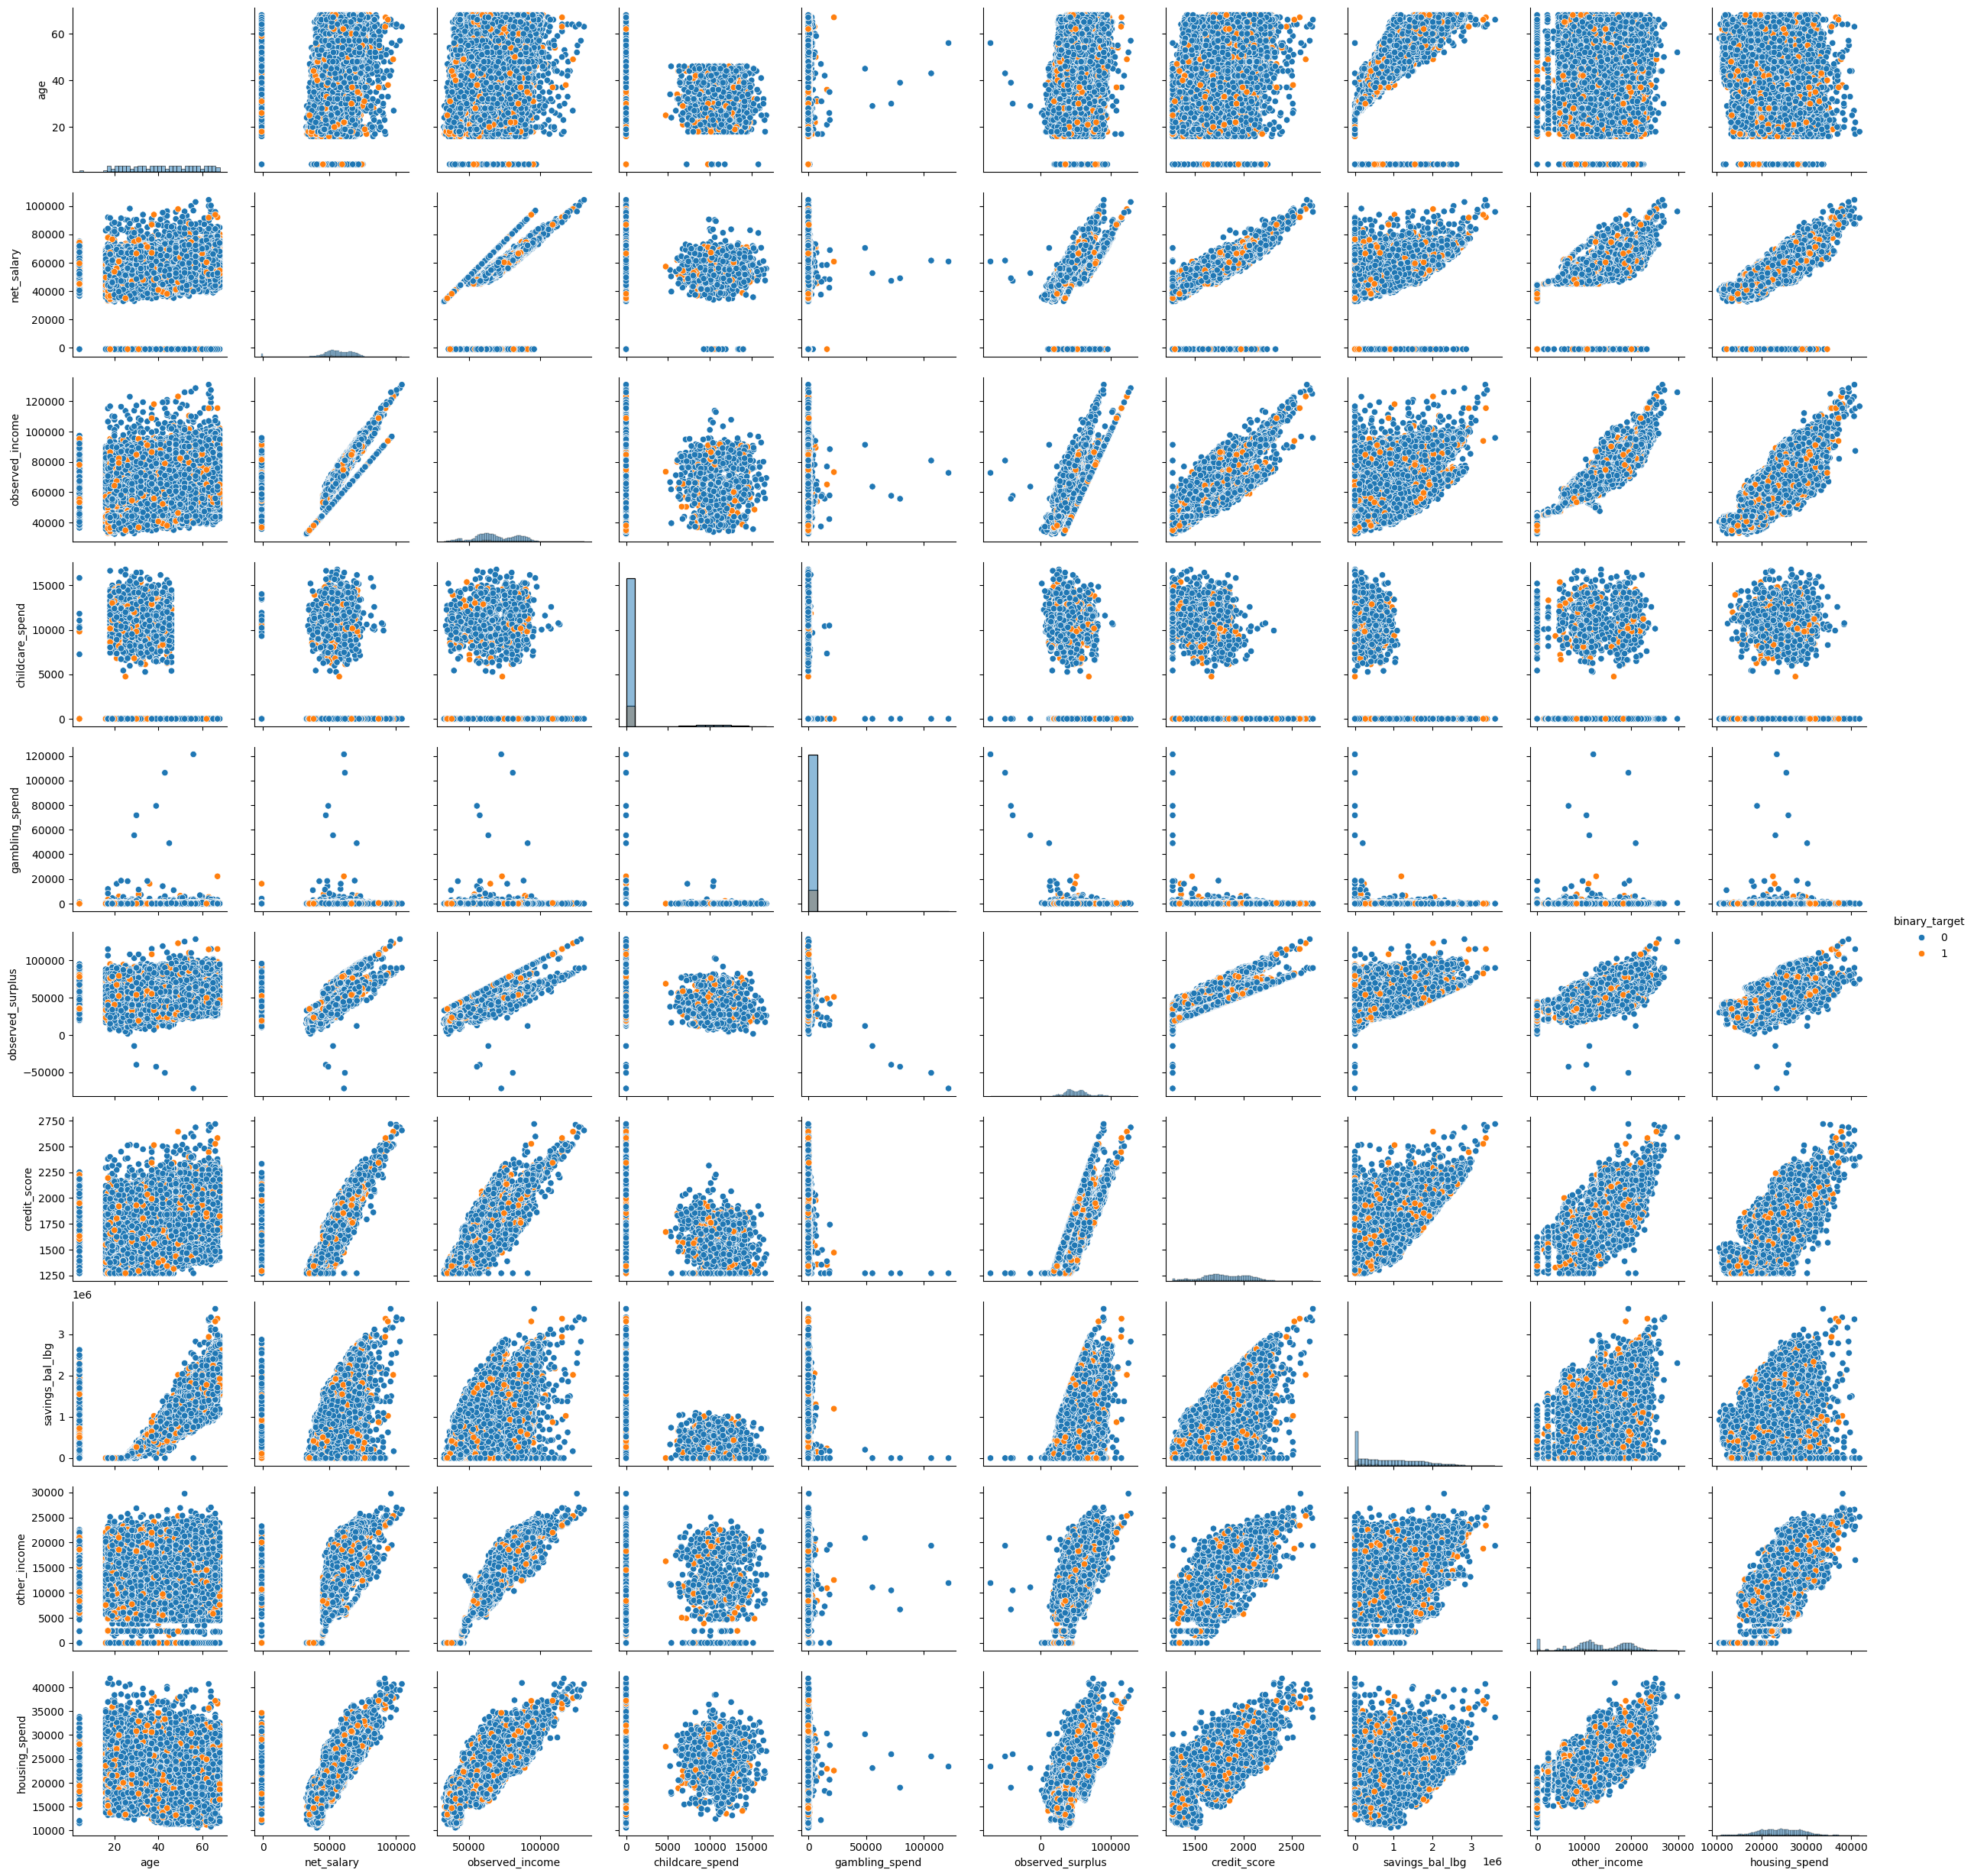

In [36]:
# Matrix of scatter plots
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
sns.pairplot(
    clean_train_df.select_dtypes(include=['number']), hue='binary_target', diag_kind='hist'
)

### Feature preprocessing

* Dummy variables were added to indicate zero values for the following features: 'zero_savings_bal' and 'zero_childcare_spend'.

* Multicollinearity was addressed by dropping 'net_salary', 'observed_income' and 'other_income'. 'Observed_surplus' was retained as the data dictionary indicates it contains information on all these features.

In [37]:
def preprocess_logistic_features(df):
    """
    Remove selected features and apply required feature engineering steps.
    """
    # Drop selected features
    df = df.drop(['net_salary', 'observed_income', 'other_income', 'cust_unique_id', 'gambling_spend'], axis=1)

    # Add dummy variable for predictive features with a high proportion of zeros
    df['zero_savings_bal'] = (df['savings_bal_lbg'] == 0).astype(int)
    df['zero_childcare_spend'] = (df['childcare_spend'] == 0).astype(int)

    # Divide predictive features from target
    y_train = df['binary_target']
    X_train = df.drop(['binary_target'], axis=1)

    return X_train, y_train

In [38]:
# Preprocess features
X_train, y_train = preprocess_logistic_features(clean_train_df)
X_train.head()

age gender ethnicity_group geo_region  childcare_spend  observed_surplus  \
0   40      F   White British  Southwest              0.0          33385.24   
1   22      M     South Asian   Scotland              0.0          34201.97   
2   32      M   White British  Southwest              0.0          64505.17   
3   27  Other   White British   Scotland              0.0          55337.96   
4   34      M   White British  Southeast              0.0          60559.66   

   credit_score  savings_bal_lbg  housing_spend  zero_savings_bal  \
0       1522.26        477383.97      18195.490                 0   
1       1563.66             0.00      23532.610                 1   
2       1708.02        271540.82      21109.689                 0   
3       1620.99         65397.27      23471.349                 0   
4       2140.43        535651.79      26054.250                 0   

   zero_childcare_spend  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

### Hyperparameter selection

**With imbalanced class distribution**

1. Class weights

    * Class weights are set to balanced. They are inversely proportional to the class frequencies:

        $\text{class weight} = \{w_{y_i}: \text{majority class instances / minority class instances}, w_{1-y_i}: 1\}$

    * The log-likelihood objective function is adjusted:
  
        $LL(\theta) = \sum_{i=1}^n  w_{y_i} \times y_ilog\bigl[\sigma(\theta^T\boldsymbol{x_i})\bigr] + w_{1-y_i} \times (1-y_i)log\bigl[1- \sigma(\theta^T\boldsymbol{x_i})\bigr]$

2. Regularisation

    * Feature selection is achieved using L1 regularisation
  
        $L_1 = \lambda \sum_{i=1}^p |w_i|$

3. Regularisation strength

    * Five-fold cross validation gridsearches are used to optimise the regularisation strength.

        Note: The regularisation parameter $\lambda$ represents the inverse of regularization strength.

In [39]:
# Create logistic regression pipeline
categorical_features = X_train.select_dtypes('object').columns
continuous_features = X_train.select_dtypes('number').columns

lr_preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), continuous_features),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)
lr_pipeline = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=10000, random_state=42))]
                   )

In [40]:
# Cross-validated grid search
cv = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=42
)
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1]
}
custom_f1_scorer = make_scorer(
    f1_score, pos_label=1
)
lr_grid_search = GridSearchCV(
    lr_pipeline, lr_param_grid, cv=cv, scoring=custom_f1_scorer
)
lr_grid_search.fit(
    X_train, y_train
)

# Access the best model's attributes
lr_best_model = lr_grid_search.best_estimator_
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_
print(lr_best_score)
print(lr_best_params)

0.19768001149406755
{'lr__C': 0.1}


**With balanced class distribution**
* Feature selection is achieved using L1 regularisation. Five-fold cross validation gridsearches are used to optimise the regularisation strength.
  
* SMOTE is used to generate synthetic samples for the minority class. The gridsearch is used to optimise the SMOTE sampling strategy (the ratio of the number of samples in the minority class over the number of samples in the majority class after resampling).

* Unfortunately, no significant difference in f1-score is achieved.

**_Synthetic Minority Over-sampling Technique (SMOTE)_**

* Working with highly imbalanced data is problematic:

    - distorted performance metrics
  
    - poor generalisation as insufficient training leads to a poor decision boundary
 
* Default settings were used due to time constraints:
  
    - $\text{nearest neighbours} = 5$
 
    - The minority class was oversampled to a balanced distribution.

* Algorithm:

    - Select a member of the minority class $x_i$ at random

    - Identify its k-nearest neighbours

    - Randomly place a new observation between $x_i$ and each of its neighbours

        $x_{new} = x_i + \lambda\bigl(x_{zi}-x_i\bigr)$

        *Where $\lambda \in [0, 1]$*

In [41]:
# Create logistic regression pipeline with SMOTE
categorical_features = X_train.select_dtypes('object').columns
continuous_features = X_train.select_dtypes('number').columns

smote_lr_preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', MinMaxScaler(), continuous_features)],
                                    remainder='passthrough')
smote_lr_pipeline = make_pipeline(
    smote_lr_preprocessor, SMOTE(random_state=42), LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=10000, random_state=42)
)

In [42]:
# Cross-validated grid search with SMOTE
cv = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=42
)
smote_lr_param_grid = {
    'smote__sampling_strategy': [0.5, 1.0],
    'logisticregression__C': [0.01, 0.1, 1]
}
custom_f1_scorer = make_scorer(
    f1_score, pos_label=1
)
smote_lr_grid_search = GridSearchCV(
    smote_lr_pipeline, smote_lr_param_grid, cv=cv, scoring='f1'
)
smote_lr_grid_search.fit(
    X_train, y_train
)

# Access the best model's attributes
smote_lr_best_model = smote_lr_grid_search.best_estimator_
smote_lr_best_params = smote_lr_grid_search.best_params_
smote_lr_best_score = smote_lr_grid_search.best_score_
print(smote_lr_best_score)
print(smote_lr_best_params)

0.19769961872310254
{'logisticregression__C': 0.1, 'smote__sampling_strategy': 0.5}


### Evaluation

* A closer look at predictive performance on validation sets during cross validation confirms poor predictive performance (indicative of a poor fit).

* Expected recall for the minority class:

    $Recall = \frac{TP}{TP + FN} = \frac{p\bigl(TP\bigr)}{p\bigl(TP\bigr) + p\bigl(FN\bigr)}$

    $Recall = \frac{pP}{pP + (1-p)P} = \frac{pP}{pP + P-pP} = p$

    *Where $P$ is the probability of an instance being class $1$, and  the random classifier outputs class $1$ with probability $p$.*

* Expected precision for the majority class:

    $Precision = \frac{TP}{TP + FP} = \frac{p\bigl(TP\bigr)}{p\bigl(TP\bigr) + p\bigl(FP\bigr)}$

    $Precision = \frac{pP}{pP + p(1-P)} = \frac{pP}{pP + p-pP} = P$

    *Where $P$ is the probability of an instance being class $1$, and  the random classifier outputs class $1$ with probability $p$.*

* In this instance:

  - $p=0.5$: A 'uniform' sampling strategy means the probability of outputting each class is the same.
 
  - $P=0.12$: The proportion of the relevant class.

Accuracy: 0.533 +/- 0.041
Precision: 0.124 +/- 0.009
Recall: 0.476 +/- 0.043
F1 Score: 0.197 +/- 0.011


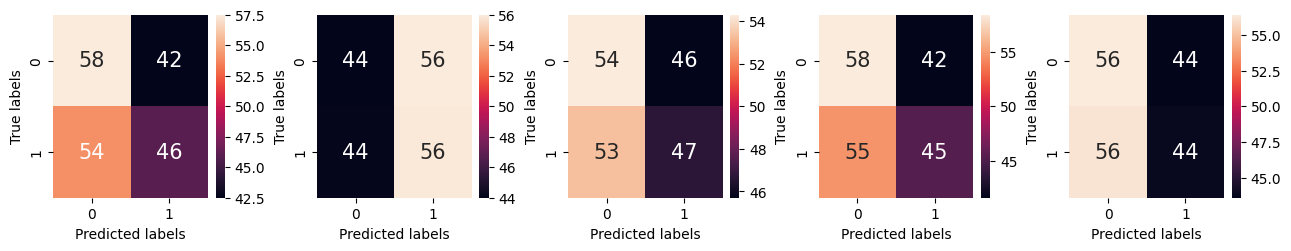

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(6.4*2, 4.8/2))
cv = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_k, y_train_k = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_k, y_test_k = X_train.iloc[test_index], y_train.iloc[test_index]

    # Fit the logistic regression pipeline
    lr_pipeline.fit(X_train_k, y_train_k)
    
    # Predict on the test set
    y_pred_k = lr_pipeline.predict(X_test_k)

    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test_k, y_pred_k))
    precision_scores.append(precision_score(y_test_k, y_pred_k))
    recall_scores.append(recall_score(y_test_k, y_pred_k))
    f1_scores.append(f1_score(y_test_k, y_pred_k))

    # Plot confusion matrix
    confusion_matrices_count = confusion_matrix(y_test_k, y_pred_k)
    confusion_matrices_perc = (confusion_matrix(y_test_k, y_pred_k, normalize='true')*100).round(1)
    labels = [f"{c}\n{p}%" for c, p in zip(confusion_matrices_count.flatten(), confusion_matrices_perc.flatten())]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrices_perc, ax=axes[i], annot=True, annot_kws={"fontsize":15})
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

print(f"Accuracy: {round(np.mean(accuracy_scores), 3)} +/- {round(np.std(accuracy_scores), 3)}")
print(f"Precision: {round(np.mean(precision_scores), 3)} +/- {round(np.std(precision_scores), 3)}")
print(f"Recall: {round(np.mean(recall_scores), 3)} +/- {round(np.std(recall_scores), 3)}")
print(f"F1 Score: {round(np.mean(f1_scores), 3)} +/- {round(np.std(f1_scores), 3)}")